## Applying K25 to SAR data

1) Larry and IWRAP

2) Dropsondes

DONE: Quelques updates sur la manière dont je fitte les asymétries

DONE: Update dans ma fonction get_new_aircraft_coords_based_on_storm_motion(): il y a bien un signe moins dans dist=-diwp.dt_scds * storm_speed

DONE: Update dans ma fonction get_wn1()

Je ne peux pas calibrer les paramètres en utilisant uniquement le champ de vent SAR, même en laissant C / sqrt(K) libre... Je dois donc utiliser une information auxiliaire juste pour calibrer C / sqrt(K). Prendre l'inflow angle d'Alexis ? Utiliser le temporel ? Juste proposer des ensembles ? Se concentrer sur les cas avec dropsondes ? Créer un ensemble de K et c2 plausibles et prendre la moyenne de ces ensembles (en enlevant par exemple les cas non physiques qui ont des wiggles) ?

Rq: Les wiggles viennent effectivement de situations où I - Vs_try / r < 0 (ne pas oublier que changer C et K changent Vs_try !!)

IDEE: Faire l'hypothese que sqrt(c1 **2 + c2 ** 2) est proportionnel ) Ut et modulé de manière sinusoidale par le wind shear; déterminer ces constantes de proportionalité et modulation (amplitude et phase) de manière statistique sur le dataset des dropsondes et appliquer tout ça au SAR. Valider sur Larry avec IWRAP. Faire une carte de C et K avec toutes les données SAR. On rappelle que le but d'utiliser K01 c'était de voir si l'asymétrie observée était cohérente avec le Ut, et sinon ça voulait dire des choses sur C/sqrt(K). Je ne peux pas faire ça dans le K25 car Ut et le wind shear n'interviennent pas directement dans le modèle. Mais ça a quand même du sens de faire une régression liénaire sur plusieurs cas et donner une estimation statistique de c1 et c2 en fonction de ces paramètres. Donc exprimer c1 et c2 uniquement en fonction de Ut et du wind shear. Le ratio c1/c2 (qui indique le front de Cd, et donc l'azimuth de l'asymétrie maximale) est probablement déterminé de manière unique par le la différence d'angle entre Ut et le wind shear vector; donc je n'ai plus qu'à déterminer sqrt(c1 **2 + c2 ** 2) en fonction de Ut, wind shear et leurs directions respectives. Ne pas oublier que C et K varient aussi !!

Drosponde data on Larry from: https://www.aoml.noaa.gov/2021-hurricane-field-program-data/#larry

TODO: Calibrate the full Kepert's model with the RMSE with the total wind speed. If that doesn't work fine I could also look at the maximum wind speed. For this put a lower z resolution maybe? Also check what's happening on Larry for K = 1? 

TODO: Check other cases which have collocations with dropsondes, in particular those that have a small Rmax, so I can handle the I ~ V/r issue.

TODO: Once my cases are calibrated, I can look at my linking c1, c2 with Ut and wind_shear.

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# Paths & Params
PTHS = {
    'iwp_dir': '/home/arthur/data/tropical_cyclones/IWRAP/',
    'dsg_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir': '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'dps_dir': '/home/arthur/data/tropical_cyclones/dropsondes/NOAA_field_experiment/samples/al122021/20210907N1_NETCDF/'
    # 'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/02_plotKepertAndSARasymmetries/',
}

In [3]:
# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

# Open Larry
ds  = dsg.where(dsg.name == 'LARRY', drop=True).sortby('time').isel(time=4)
dsp = xr.open_dataset(PTHS['sar_dir'] + 's1b-ew-owi-ca-20210907t214630-20210907t215005-000003-0369AB_sw_al122021_cyclone_polar.nc').isel(time=0)

In [4]:
#########################
### General functions ###
#########################
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

#########################
### KEPERT 2001 MODEL ###
#########################
# Inertial stability
def I(Rs, Vs, fcor):
    dr   = np.diff(Rs[0, :])[0] # meters
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=1) + Vs / Rs + fcor
    return np.sqrt(ksi * zeta)

# Coefficients
def sqrt_alpha_beta(Rs, Vs, fcor):
    '''Corresponds to sqrt(alpha / beta).'''
    dr   = np.diff(Rs[0, :])[0] # meteRs
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=1) + Vs / Rs + fcor
    return np.sqrt(ksi / zeta)

def eta(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * ((Vs / Rs) + I(Rs, Vs, fcor))))

def ki(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * I(Rs, Vs, fcor)))

def psi(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * abs((Vs / Rs) - I(Rs, Vs, fcor))))

# Amplitudes
def A0(Rs, Vs, K, C, fcor):
    num = -ki(Rs, Vs, K, C, fcor) * Vs * [1 + 1j * (1 + ki(Rs, Vs, K, C, fcor))]
    den = 2 * ki(Rs, Vs, K, C, fcor) ** 2 + 3 * ki(Rs, Vs, K, C, fcor) + 2
    return num / den

def A1(Rs, Vs, K, C, c1, c2, fcor):
    '''Note the error of parenthesis in his Eq. 29 - I re-computed the exact coefficients, the parenthesis should be removed.'''
    # New notations
    ki0  = ki(Rs, Vs, K, C, fcor)
    ki1  = eta(Rs, Vs, K, C, fcor)
    ki_1 = psi(Rs, Vs, K, C, fcor)
    # New expressions
    num  = (c1 - 1j * c2) * ki1 * [(3 + 1j) * ki0 * ki_1 + (2 - 2j) * (ki0 + ki_1) - 4j] * abs(Vs)
    den  = 2 * (2 * ki0 ** 2 + 3 * ki0 + 2) * [(2 + 2j) * (1 + ki1 * ki_1) + 3 * ki1 + 3j * ki_1]
    return num / den

def A_1(Rs, Vs, K, C, c1, c2, fcor):
    '''Note the error of parenthesis in his Eq. 29 - I re-computed the exact coefficients, the parenthesis should be removed.'''
    # New notations
    ki0  = ki(Rs, Vs, K, C, fcor)
    ki1  = eta(Rs, Vs, K, C, fcor)
    ki_1 = psi(Rs, Vs, K, C, fcor)
    # New expressions
    num  = (c1 + 1j * c2) * ki_1 * [(3 + 1j) * ki0 * ki1 + (2 - 2j) * (ki0 + ki1) - 4j] * abs(Vs)
    den  = 2 * (2 * ki0 ** 2 + 3 * ki0 + 2) * [(2 + 2j) * (1 + ki1 * ki_1) + 3 * ki_1 + 3j * ki1]
    return num / den

def A1_prime(Rs, Vs, K, C, c1, c2, fcor):
    # New notations
    ki0  = ki(Rs, Vs, K, C, fcor)
    ki1  = eta(Rs, Vs, K, C, fcor)
    ki_1 = psi(Rs, Vs, K, C, fcor)
    # New expressions
    num  = (c1 - 1j * c2) * ki1 * [(1 - 3j) * ki0 * ki_1 + (2 - 2j) * ki0 - (2 + 2j) * ki_1 - 4j] * abs(Vs)
    den  = 2 * (2 * ki0 ** 2 + 3 * ki0 + 2) * [2 + 2j + 3 * (ki1 + ki_1) + (2 - 2j) * ki1 * ki_1]
    return num / den

def A_1_prime(Rs, Vs, K, C, c1, c2, fcor):
    # New notations
    ki0  = ki(Rs, Vs, K, C, fcor)
    ki1  = eta(Rs, Vs, K, C, fcor)
    ki_1 = psi(Rs, Vs, K, C, fcor)
    # New expressions
    num  = (c1 + 1j * c2) * ki_1 * [1j * (1 - 3j) * ki0 * ki1 + (2 - 2j) * ki0 + (2 + 2j) * ki1 - 4j] * abs(Vs)
    den  = 2 * (2 * ki0 ** 2 + 3 * ki0 + 2) * [2 - 2j + 3 * (ki1 + ki_1) + (2 + 2j) * ki1 * ki_1]
    return num / den

# Thicknesses
def delta0(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor)))

def delta1(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor) + Vs / Rs))

def delta_1(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor) - Vs / Rs))

# Radial and tangential wind components
def u0(Rs, Vs, K, C, fcor, z, z_ref):
    u0 = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A0(Rs, Vs, K, C, fcor) * np.exp(- (1 + 1j) * (z - z_ref) / delta0(Rs, Vs, K, fcor)))
    return np.reshape(u0,  np.shape(u0)[1:])

def v0(Rs, Vs, K, C, fcor, z, z_ref):
    v0 = np.imag(A0(Rs, Vs, K, C, fcor) * np.exp(- (1 + 1j) * (z - z_ref) / delta0(Rs, Vs, K, fcor)))
    return np.reshape(v0,  np.shape(v0)[1:])

def u1(THs, Rs, Vs, K, C, c1, c2, fcor, z, z_ref, h):
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * (z - z_ref) / delta1(Rs, Vs, K, fcor) + 1j * h * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 + 1j) * (z - z_ref) / delta1(Rs, Vs, K, fcor) + 1j * h * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v1(THs, Rs, Vs, K, C, c1, c2, fcor, z, z_ref, h):
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * (z - z_ref) / delta1(Rs, Vs, K, fcor) + 1j * h * THs))
    otherwise = np.imag(A1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 + 1j) * (z - z_ref) / delta1(Rs, Vs, K, fcor) + 1j * h * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

def u_1(THs, Rs, Vs, K, C, c1, c2, fcor, z, z_ref, h):
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * (z - z_ref) / delta_1(Rs, Vs, K, fcor) - 1j * h * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 - 1j) * (z - z_ref) / delta_1(Rs, Vs, K, fcor) - 1j * h * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v_1(THs, Rs, Vs, K, C, c1, c2, fcor, z, z_ref, h):
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A_1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * (z - z_ref) / delta_1(Rs, Vs, K, fcor) - 1j * h * THs))
    otherwise = np.imag(A_1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 - 1j) * (z - z_ref) / delta_1(Rs, Vs, K, fcor) - 1j * h * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

# TOTAL WIND COMPONENTS IN THE BL
def u_BL(THs, Rs, Vs, K, C, c1, c2, fcor, z, z_ref, h):
    return u_1(THs, Rs, Vs, K, C, c1, c2, fcor, z, z_ref, h) + u0(Rs, Vs, K, C, fcor, z, z_ref) + u1(THs, Rs, Vs, K, C, c1, c2, fcor, z, z_ref, h)

def v_BL(THs, Rs, Vs, K, C, c1, c2, fcor, z, z_ref, h):
    return Vs + v_1(THs, Rs, Vs, K, C, c1, c2, fcor, z, z_ref, h) + v0(Rs, Vs, K, C, fcor, z, z_ref) + v1(THs, Rs, Vs, K, C, c1, c2, fcor, z, z_ref, h)

# FINAL MODEL
def kepert2025(THs, Rs, Vs, K, C, c1, c2, fcor, z, z_ref, h):
    # Returns Kepert wind speeds
    u_K01   = u_BL(THs, Rs, Vs, K, C, c1, c2, fcor, z, z_ref, h)
    v_K01   = v_BL(THs, Rs, Vs, K, C, c1, c2, fcor, z, z_ref, h)  

    # Not for K25!!!
    # # Adds the translation speed
    # Utu     = Ut * np.cos(THs) # Radial component of Ut
    # Utv     = -Ut * np.sin(THs) # Tangential component of Ut
    # # Utu = Utv = 0
    
    # return u_K01 + Utu, v_K01 + Utv
    return u_K01, v_K01

#########################
### CREATE STRUCTURES ###
#########################
def get_xrDataset_polar(rs, ths, u_K01, v_K01):
    kep_pol = xr.Dataset(
        data_vars={
            'wind_speed': (('theta', 'rad'), np.sqrt(v_K01 ** 2 + u_K01 ** 2)),
            'rad_wind':   (('theta', 'rad'), u_K01),
            'tan_wind':   (('theta', 'rad'), v_K01),
        },
        coords={
            'theta': np.rad2deg(ths),
            'rad': rs,
        }
    )
    kep_pol['inflow_angle'] = np.rad2deg(np.arctan((kep_pol.rad_wind / kep_pol.tan_wind))) # Inflow Angle Polar
    return kep_pol

def get_xrDataset_cartesian(Xs, Ys, x_ref, y_ref, dim_ref, kep_pol):
    '''Slower than its polar counterpart, because 4 interpolations are performed.'''
    kep_car = xr.Dataset(
        data_vars={
            'wind_speed':   (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.wind_speed).flatten(),   (x_ref, y_ref), method='nearest')),
            'rad_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.rad_wind).flatten(),     (x_ref, y_ref), method='nearest')),
            'tan_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.tan_wind).flatten(),     (x_ref, y_ref), method='nearest')),
            'inflow_angle': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.inflow_angle).flatten(), (x_ref, y_ref), method='nearest')),
        },
        coords={
            'x': dim_ref,
            'y': dim_ref,
        }
    )
    return kep_car

#########################
###   MODEL FITTING   ###
#########################
def wind_reduction_factor(Rs, Vs, K, C, fcor):
    '''wrf = surface azim. wind / gradient azim. wind'''
    ki_cst  = ki(Rs, Vs, K, C, fcor)
    num     = ki_cst ** 2 + 2 * ki_cst + 2
    den     = 2 * ki_cst ** 2 + 3 * ki_cst + 2
    return num / den

def wn1(thetas, a, phi, c):
    return a * np.cos(thetas - phi) + c

def get_wn1(thetas, wind_speed, initial_condition=15, upper_bound=80):
    '''
    initial_condition: initial conidition for the amplitude and the constant c (just put Vplus)
    upper_bound: upper bound for the the amplitude and the constant c (just put Vmax)
    '''
    # Fitting process
    popt, pcov = curve_fit(
        f=wn1,
        xdata=thetas,
        ydata=wind_speed,
        p0=[initial_condition, np.pi, initial_condition],
        bounds=([0.01, 0., 0.1], [upper_bound, 2 * np.pi, upper_bound]) # ([lower bounds], [upper bounds])
    )
    a, phi, c = popt[0], popt[1], popt[2]
    return a, phi, c

def get_kepert_asymmetries(THs, Rs, ths, rs, Vs, K, C, c1, c2, fcr, z_ref, h, valid_radii):
    # Estimate the wind at the top of the BL with the wind reduction factor
    wrf          = wind_reduction_factor(Rs, Vs, K, C, fcr) # azimuthal wind
    Vs_try       = Vs / wrf

    # Apply Kepert's model
    u_K25, v_K25 = kepert2025(THs, Rs, Vs_try, K, C, c1, c2, fcr, z_ref, z_ref, h) # Takes 3-4 seconds
    kep_pol      = get_xrDataset_polar(rs, ths, u_K25, v_K25)

    # Compute asymmetries on Kepert wind field
    aks         = []
    pks         = []
    # Iterate over all radii
    for rad in tqdm(valid_radii): # Iterate only in the valid range to optimize time
        ak, phi, _  = get_wn1(np.deg2rad(kep_pol.theta), kep_pol.wind_speed.sel(rad=rad, method='nearest'), np.max(Vs[0, :]) / 3, np.max(Vs[0, :]))
        aks.append(ak)
        pks.append(phi)
    
    return aks, pks, kep_pol

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

#########################
###       PLOT        ###
#########################
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def getColorMap(rgbFile="medspiration.rgb"):
    '''
    Load a RGB palette provided in ascii file
    '''
    colors = []
    nbCol  = 0
    for line in open( rgbFile ):
        r,g,b = [int(c) for c in line.split()]
        colors.append( [r/255.,g/255.,b/255.] )
        nbCol += 1
    return(mpl.colors.ListedColormap(colors, name="custom", N=nbCol))

palette = '/home/arthur/scripts/tools/high_wind_speed.pal'
cwnd         = getColorMap(rgbFile=palette)
normalizer   = Normalize(0, 80)

In [5]:
def get_z_kepert(THs, Rs, ths, rs, zs, Vs, K, C, c1, c2, fcr, z_ref, h):
    # Estimate the wind at the top of the BL with the wind reduction factor
    # LINES TO UNCOMMENT, JUST FOR THE CHECKING NOTEBOOK
    # Also change the inside of the kepert2025 call!!
    wrf          = wind_reduction_factor(Rs, Vs, K, C, fcr) # azimuthal wind
    Vs_try       = Vs / wrf
    # # And comment this line below instead:
    # Vs_try = Vs

    # Apply Kepert's model at each z
    # TODO: Vectorize all my functions?
    U_K01, V_K01 = [], []
    for z in tqdm(zs):
        u_K01, v_K01 = kepert2025(THs, Rs, Vs_try, K, C, c1, c2, fcr, z, z_ref, h) # Takes 3-4 seconds
        U_K01.append(u_K01)
        V_K01.append(v_K01)
    
    # Polar dataset
    kep_pol = xr.Dataset(
        data_vars={
            'wind_speed': (('z', 'theta', 'rad'), np.sqrt(np.array(V_K01) ** 2 + np.array(U_K01) ** 2)),
            'rad_wind':   (('z', 'theta', 'rad'), np.array(U_K01)),
            'tan_wind':   (('z', 'theta', 'rad'), np.array(V_K01)),
        },
        coords={
            'z': zs,
            'theta': np.rad2deg(ths),
            'rad': rs,
        }
    )
    kep_pol['inflow_angle'] = np.rad2deg(np.arctan((kep_pol.rad_wind / kep_pol.tan_wind))) # Inflow Angle Polar
    print('Polar dataset created.')

    # Cartesian dataset
    KEP_CARS = []
    for z in tqdm(zs): # Takes ~20 seconds
        kep_car = xr.Dataset(
            data_vars={
                'wind_speed':   (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).wind_speed).flatten(),   (x_ref, y_ref), method='nearest')),
                'rad_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).rad_wind).flatten(),     (x_ref, y_ref), method='nearest')),
                'tan_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).tan_wind).flatten(),     (x_ref, y_ref), method='nearest')),
                'inflow_angle': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).inflow_angle).flatten(), (x_ref, y_ref), method='nearest')),
            },
            coords={
                'x': dim_ref,
                'y': dim_ref,
            }
        )
        KEP_CARS.append(kep_car)
    kep_car = xr.concat(KEP_CARS, 'z').assign_coords({'z': zs})
    print('Cartesian dataset created.')

    return kep_pol, kep_car

# For the expression see e.g Ueno and Kunii 2009
def get_w(kep_pol, kep_car, zs):
    # Compute vertical velocity by integrating continuity equation
    dru_dr = (kep_pol.rad * kep_pol.rad_wind).differentiate('rad') # d(ru)/dr
    dv_dth = kep_pol.tan_wind.differentiate('theta') / (2 * np.pi / 360) # dv/dtheta, dtheta converted in radians here
    # dv_dth = kep_pol.tan_wind.differentiate('theta')               # dv/dtheta
    WS_POL = []
    WS_CAR = []
    for z in tqdm(zs):
        integral = (dru_dr + dv_dth).sel(z=slice(None, z)).integrate('z')
        w_pol    = - (1 / integral.rad) * integral
        WS_POL.append(w_pol)
        w_car = griddata((Xs.flatten(), Ys.flatten()), np.array(w_pol.transpose()).flatten(), (x_ref, y_ref), method='nearest')
        WS_CAR.append(xr.DataArray(w_car, coords={'x': dim_ref,'y': dim_ref}))
    kep_pol['w'] = xr.concat(WS_POL, dim='z')
    kep_car['w'] = xr.concat(WS_CAR, dim='z')
    return kep_pol, kep_car

In [6]:
### FUNCTIONS TO COMPUTE ASYMMETRY AMPLITUDE
### FITS HOLLAND AT EACH RADIUS

def initialize_radius(spdm):
    '''Given the spdm, returns the largest radius (and asociated spdm) on which the profile can be fitted. 
    Indeed, sometimes the spdm isn't defined from r = 0 to r = 500, in this case the largest domain is taken instead.'''
    # Initialize first and last indexes
    first_valid_index = 0
    last_valid_index  = len(spdm)
    r                 = np.arange(last_valid_index) # to avoid having both r = 0 and n < 0 during fitting process
    
    ### Lower bound
    # We change it if spdm[0] = nan
    if np.isnan(spdm[0]):
        first_valid_index = np.min(np.where(np.isfinite(spdm)))
        
    ### Upper bound
    # We change it if there is a nan somewhere
    if np.isnan(np.min(spdm[first_valid_index:])):
        last_valid_index  = np.min(np.where(np.isnan(spdm[first_valid_index:]))[0]) # returns the index of the last valid value before the first nan
        last_valid_index += first_valid_index - 1
        
    # Define r and spdm
    r    = r[first_valid_index:last_valid_index] * 1000
    spdm = spdm[first_valid_index:last_valid_index]
    
    return r, spdm

# Test - Compute asymmetry by computing an average Holland per theta slice to smooth all the noise
BDS_HOL = {
    'B':      [0.01, 3.],
    'Vmin':   [0, 50],
    'Rmax':   [5 * 1000, 500 * 1000],
    'Vmax':   [10, 100],   
}

# Define the steps
# TODO: I could refine how I choose these steps to make them more continuous
# th_steps = np.linspace(0, 340, 341)
th_steps = np.linspace(0, 360, 19)[:-1] # Slice of 20 degrees
th_delta = 20 # degrees

In [7]:
#########################
###  HYPERPARAMETERS  ###
#########################
### Reference grids
# For K25
rs           = np.linspace(100, 5e5, 5000)
ths          = np.linspace(0, 2 * np.pi, 361)                         # in radians
# zs           = np.array([10, 110, 210, 310, 510, 1010, 1510, 2010])   # meters
zs           = np.array([10])
Rs, THs      = np.meshgrid(rs, ths)                                   # shape (361, 5000)
Xs, Ys       = pol2cart(Rs, THs)                                      # to create cartesian dataset
dim_ref      = np.linspace(-500, 500, int((500 // 1 * 2) + 1)) * 1000 # to create cartesian dataset
x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)                          # to create cartesian dataset

# To compute asymmetries
xs           = np.linspace(1000, 250000, 250)

# BL characteristics
z_ref = 10
h     = 1
C  = 1.5e-3            # fixed
# Ks = [1, 50, 100, 150] # trial
Ks = [10, 20, 30, 40, 50, 100, 150] # trial
Ks = [50, 100]
# Ks = [100]
c1 = 0
c2 = 0.5

# Colors
truncated_Reds = truncate_colormap(mpl.cm.Reds, 0.2, 1.)
colors         = truncated_Reds(np.linspace(0, 1, len(Ks)))

In [8]:
#########################
###  DET. PARAMETERS  ###
#########################
vmx = float(ds.vmx_hol)
rmx = float(ds.rmx_hol)
vmn = float(ds.vmn_hol)
B   = float(ds.B_hol)
lat = float(ds.lat)
fcr = abs(float(ds.fcor))
Ut  = float(ds.speed)

# Holland with fixed parameters
V   = holland_profile(rs, lat, B, vmn, rmx, vmx)
Vs  = np.stack([V for i in range(np.shape(THs)[0])]) # Shape (361, 5000)

In [9]:
LWS = [] # To save the Holland wind speeds
ERR = [] # To compute RMSE
ACN = [] # Amplitude of cosine
PHS = [] # Phase of cosine
VTS = [] # Nb of valid thetas

for th in tqdm(th_steps):
    ds_slice          = dsp.sel(theta=slice(th, th + th_delta))
    wsm               = ds_slice.wind_speed.mean(dim='theta', skipna=True)
    r_crop, spdm_crop = initialize_radius(np.array(wsm))

    try:
        # Holland
        popt, pcov = curve_fit(
            lambda r, B, Vmin, Rmax, Vmax: holland_profile(r, lat, B, Vmin, Rmax, Vmax), 
            np.array(r_crop), 
            np.array(spdm_crop), 
            p0=[1.8, 5, 20 * 1000, 40], 
            bounds=(
                tuple([BDS_HOL[e][0] for e in BDS_HOL.keys()]), # NB: lat is fixed
                tuple([BDS_HOL[e][1] for e in BDS_HOL.keys()])
            ) 
        ) 
        B_hol, vmn_hol, rmx_hol, vmx_hol = popt
        
    except RuntimeError:
        B_hol = vmn_hol = rmx_hol = vmx_hol = np.nan
    
    # Append
    LWS.append(holland_profile(rs, lat, B_hol, vmn_hol, rmx_hol, vmx_hol))

dsh = xr.Dataset(
    data_vars={
        'ws':        (('th', 'rad'), LWS),
    },
    coords={
        'th': th_steps,
        'rad': rs,
    }
)

for rad in tqdm(xs):
# for rad in tqdm(xs):
    # Amplitude of cosine
    acn, phi, c   = get_wn1(np.deg2rad(dsh.sel(rad=rad, method='nearest').th), dsh.sel(rad=rad, method='nearest').ws, float(ds.vps), float(ds.vmx))
    ACN.append(acn)
    PHS.append(phi)
    # Error
    error         = float(rmse(dsh.sel(rad=rad, method='nearest').ws, wn1(np.deg2rad(dsh.th), acn, phi, c))) 
    ERR.append(error)
    # Valid thetas
    VTS.append(len(dsp.sel(rad=rad, method='nearest').dropna(subset=['wind_speed'], dim='theta').theta))

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [10]:
# dsh.sel(rad=rad, method='nearest').ws.plot()
# plt.plot(dsh.th, wn1(np.deg2rad(dsh.th), acn, phi, c))

### Computing and imposing the ratio c1/c2

#### 1) Apply K25 with arbitrary C, K, c1 and c2

In [11]:
# We compute the phase of the cosine at 2 * Rmax
phs_2rmx = np.array(PHS)[xs >= 2 * rmx][0]
# We thus obtain the ratio c1 / c2
# Indeed, we must have h * arctan(c1 / c2) + 270° = phs_2rmx
c1_c2    = np.tan((phs_2rmx - 3 * np.pi / 2) / h)
print(c1_c2)

-0.17420202870044432


In [12]:
# Kepert model
AKS      = dict.fromkeys(Ks)
PKS      = dict.fromkeys(Ks)
KEP_POLS = dict.fromkeys(Ks)
for i, K in enumerate(tqdm(Ks)):
    aks, pks, kep_pol = get_kepert_asymmetries(THs, Rs, ths, rs, Vs, K, C, c1, c2, fcr, z_ref, h, xs)
    AKS[K]       = aks
    PKS[K]       = pks
    KEP_POLS[K]  = kep_pol

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

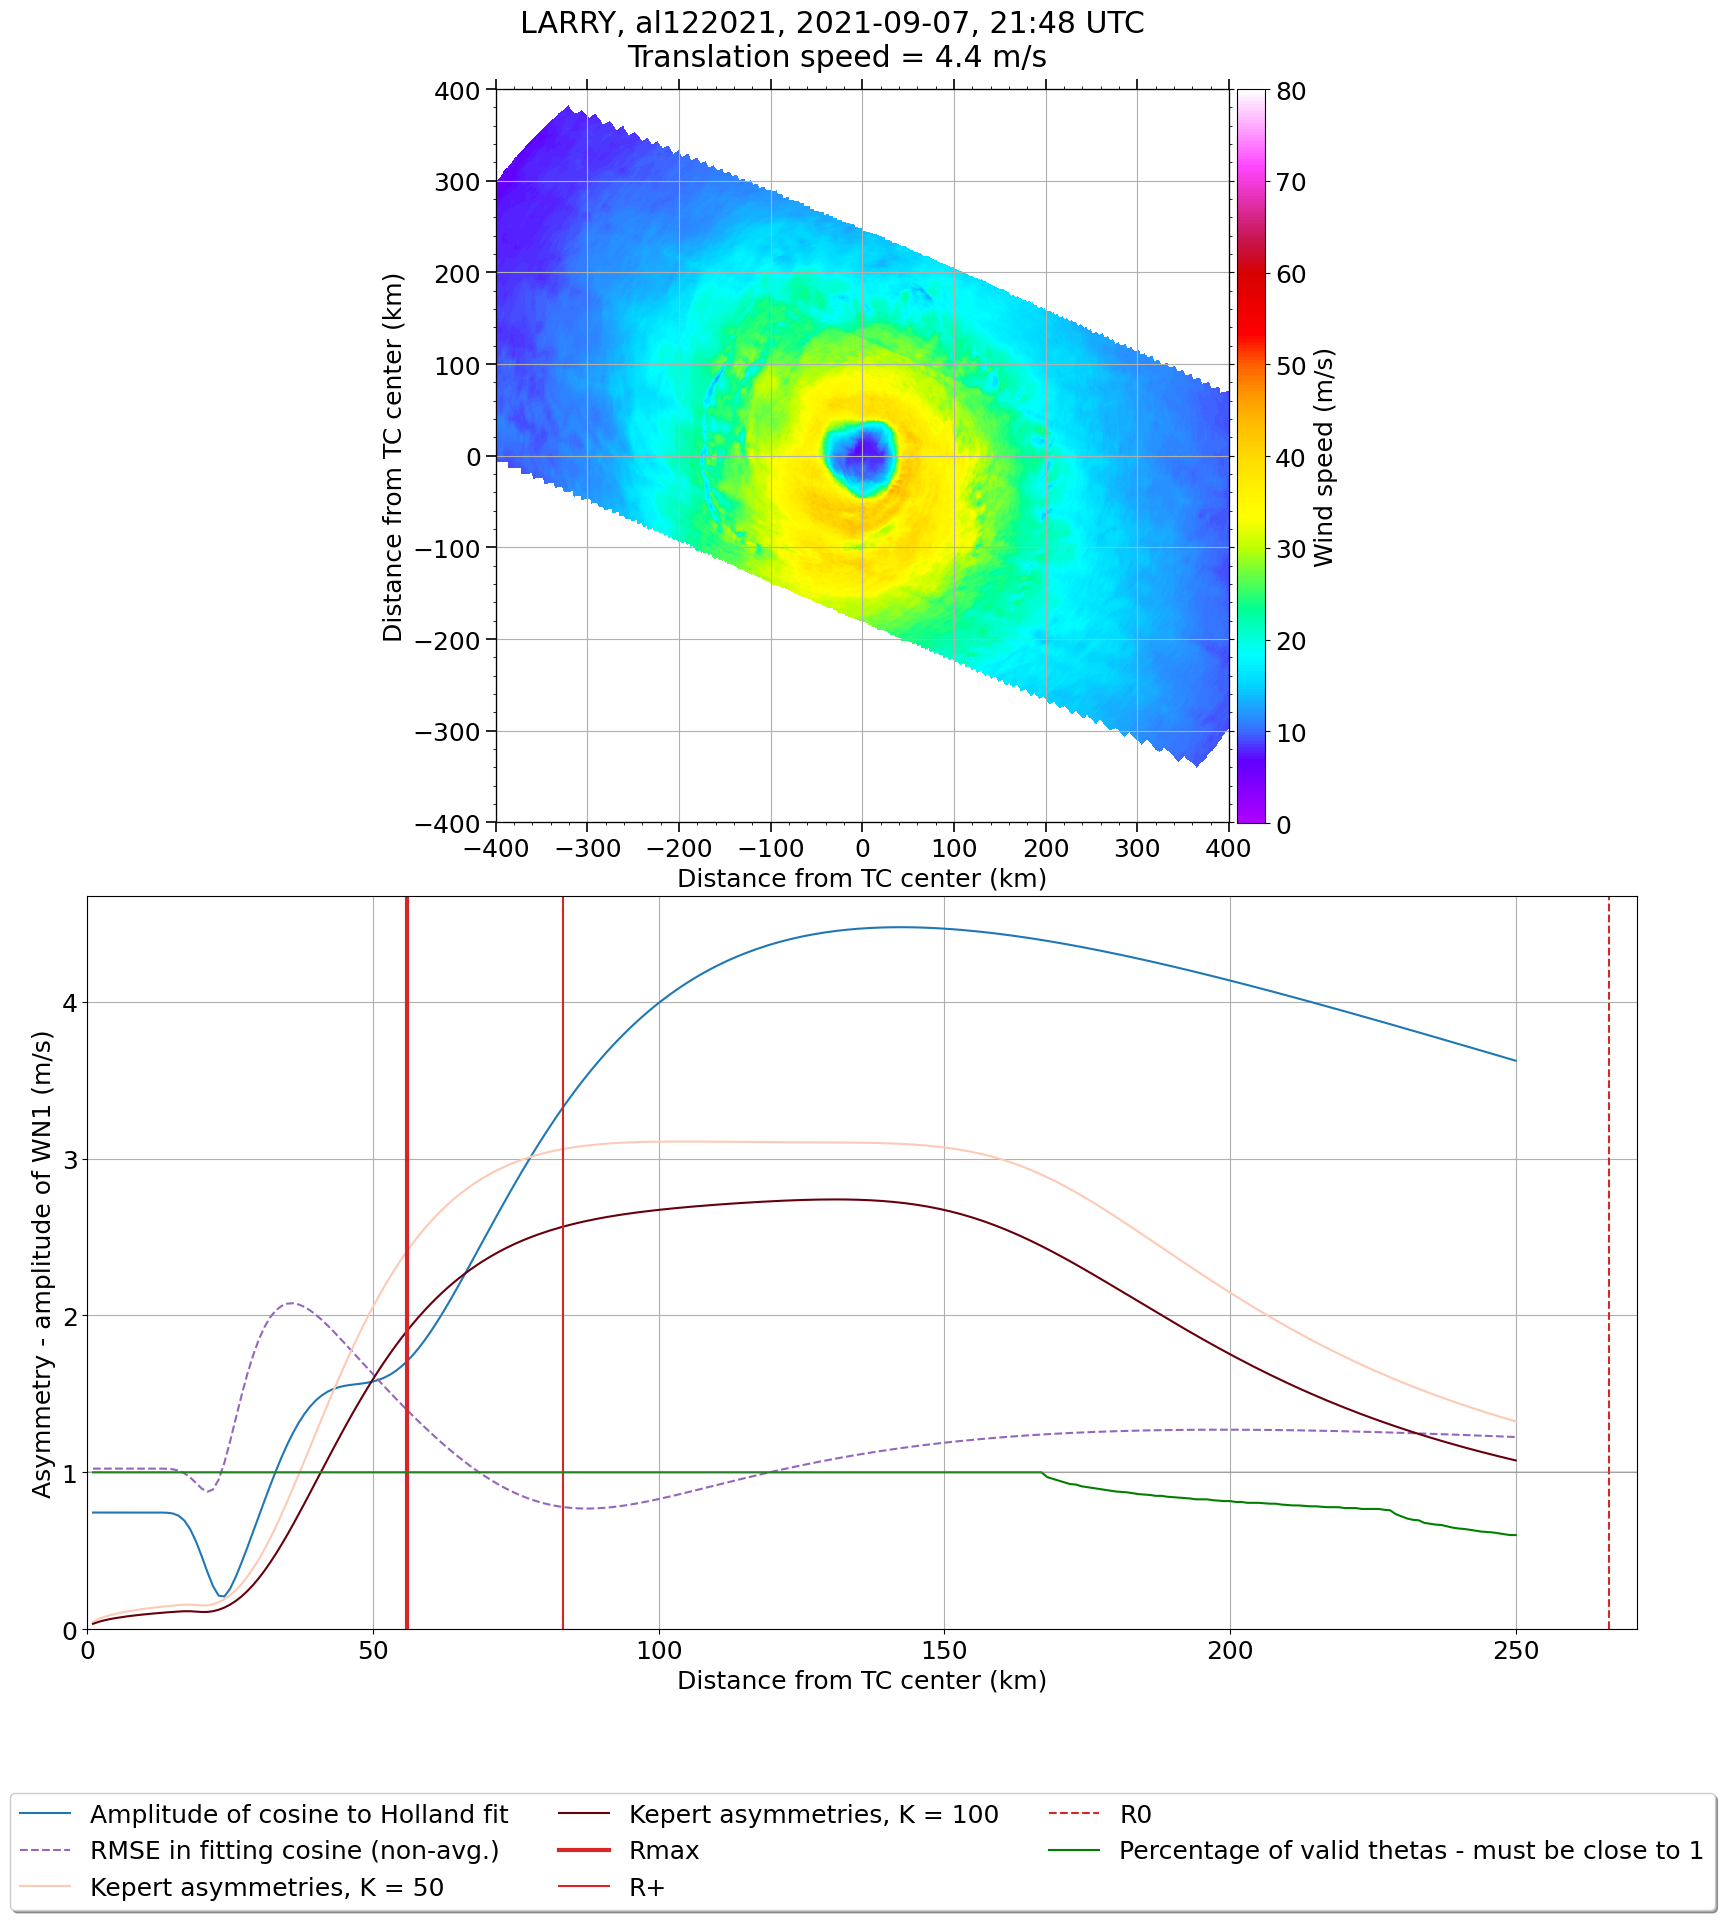

In [13]:
############
### Plot ###
############
fig          = plt.figure(figsize=(20, 20))
gs           = GridSpec(2, 1, hspace=0.1, wspace=0.01)
cmap         = plt.get_cmap('PuOr') # Spectral
normalizer   = Normalize(0, 80)
ax_lims2D    = 400
ts           = pd.to_datetime(str(ds.time.values)) 
d            = ts.strftime('%Y-%m-%d, %H:%M')
plt.suptitle('{}, {}, {} UTC \nTranslation speed = {:.1f} m/s'.format(ds.name.item(), ds.id.item(), d, ds.speed), y=0.92)

### Plot SAR
ax           = fig.add_subplot(gs[0, 0])
dr, th       = np.meshgrid(dsp.rad, np.deg2rad(dsp.theta))
ds_x, ds_y   = pol2cart(dr, th)
ws_car       = griddata((ds_x.flatten(), ds_y.flatten()), np.array(dsp.wind_speed.transpose()).flatten(), (x_ref, y_ref), method='linear')
im           = ax.pcolormesh(x_ref / 1000, y_ref / 1000, ws_car, cmap=cwnd, norm=normalizer)

# Axes
ax.set_xlim(-ax_lims2D, ax_lims2D);ax.set_ylim(-ax_lims2D, ax_lims2D)
ax.set_ylabel(r'Distance from TC center (km)')
ax.set_xlabel(r'Distance from TC center (km)')
ax.set_box_aspect(1)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.grid()

ax2 = ax.twinx().twiny() 
ax2.set_xlim(-ax_lims2D, ax_lims2D);ax2.set_ylim(-ax_lims2D, ax_lims2D)
ax2.minorticks_on()
ax2.tick_params(axis='both', length=7, width=1.2)
ax2.set_box_aspect(1)
ax2.set_yticklabels([])
ax2.set_xticklabels([])

# Colorbar
cb_ax = fig.add_axes([0.7, 0.513, 0.014, 0.367])
cbar  = fig.colorbar(im, cax=cb_ax)
cbar.set_label(r'Wind speed (m/s)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

### Plot asymmetries (SAR + Kepert)
ax       = fig.add_subplot(gs[1, 0])

ax.plot(xs / 1000, ACN, c='tab:blue',                       label='Amplitude of cosine to Holland fit')
ax.plot(xs / 1000, ERR, c='tab:purple', linestyle='dashed', label='RMSE in fitting cosine (non-avg.)')
# Kepert asymmetry profiles
for i, K in enumerate(Ks):
    ax.plot(xs / 1000, AKS[K],                 c=colors[i],                        label='Kepert asymmetries, K = {}'.format(K))
# Wind radii
ax.axvline(ds.rmx / 1000,                      c='tab:red',    linewidth=3,        label='Rmax')
ax.axvline(ds.rps / 1000,                      c='tab:red',                        label='R+')
ax.axvline(ds.r0 / 1000,                       c='tab:red',    linestyle='dashed', label='R0')

# # I ~ V/r
# ax.axvline(ds.I_Vr1 / 1000,                    c='orange',                         label='I ~ V/r with SAR wind speed (not BL-top)')
# ax.axvline(ds.I_Vr2 / 1000,                    c='orange')

# Validity curves
ax.plot(xs / 1000, np.array(VTS) / 360., c='green',                          label='Percentage of valid thetas - must be close to 1')
# ax.plot(xs / 1000, Ut / Vs[0, idxs],      c='green',      linestyle='dashed', label='Ut / V - must remain small')
ax.axhline(1, c='gray', alpha=0.3)

# Legends
ax.set_xlabel(r'Distance from TC center (km)')
ax.set_ylabel('Asymmetry - amplitude of WN1 (m/s)')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=3, fancybox=True, shadow=True)
ax.set_xlim(0, max(float(ds.r0 / 1000) + 5, 250))
ax.set_ylim(0, 0.2 + float(max(max(ACN), max(ERR))))
ax.grid()

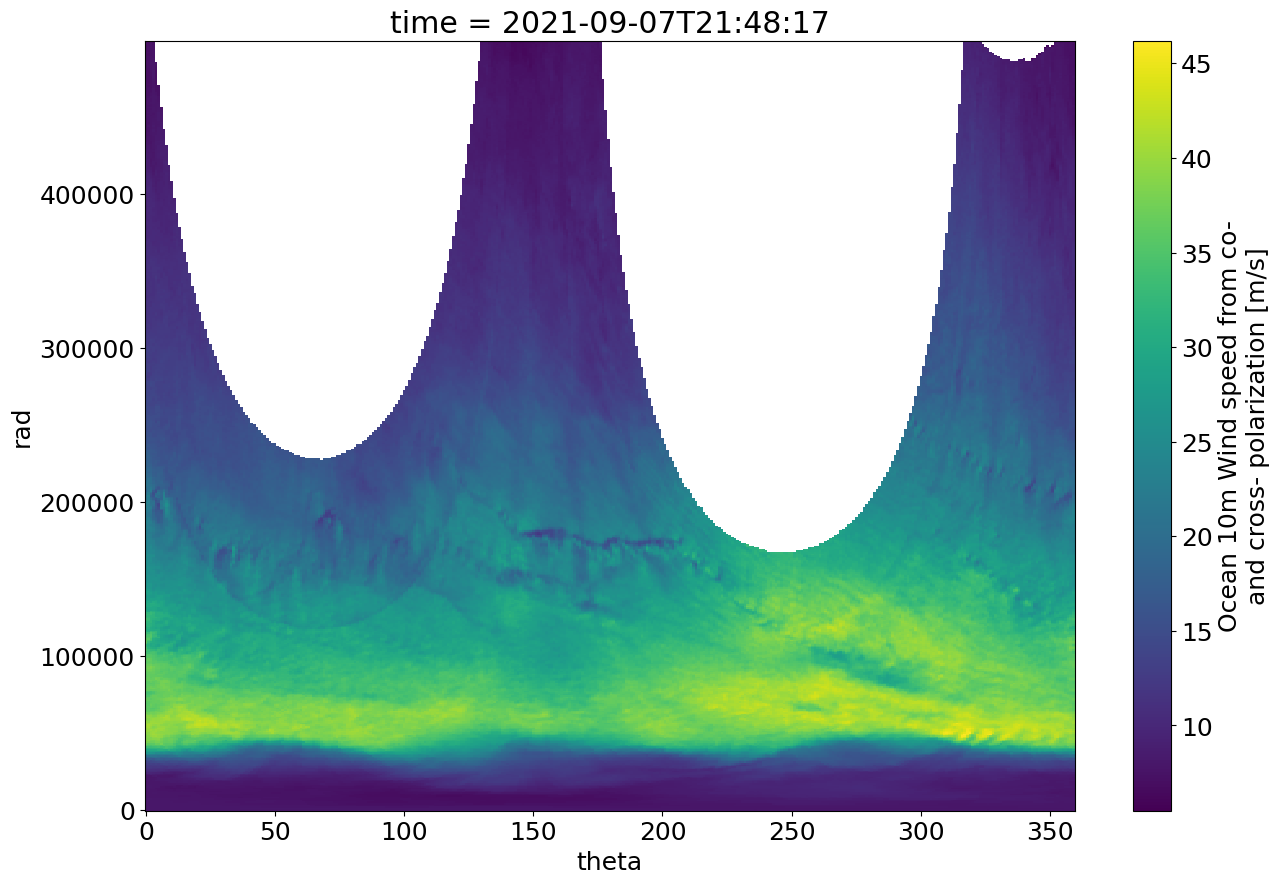

In [14]:
dsp.wind_speed.plot()

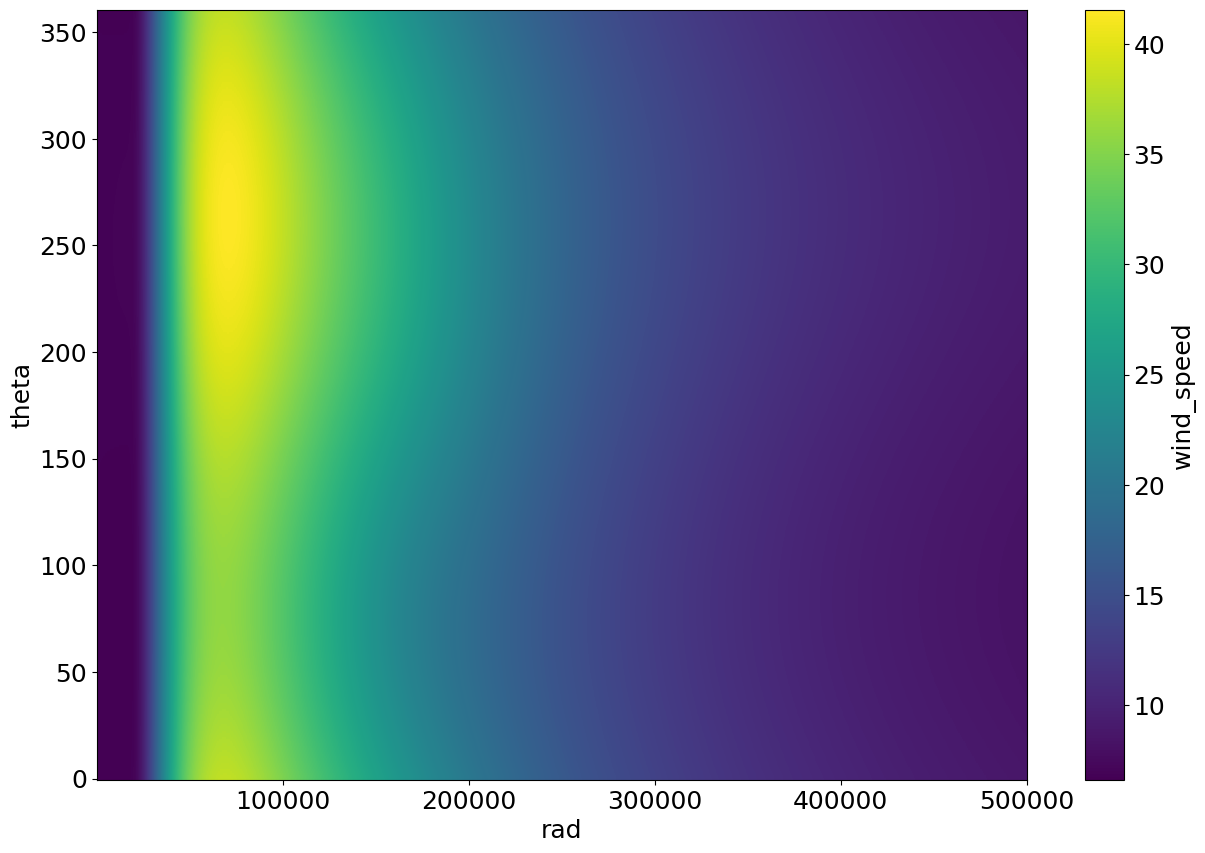

In [15]:
KEP_POLS[50].wind_speed.plot()

#### 2) Impose the ratio c1/c2, with arbitrary c2 and C, and varying K

In [16]:
C  = 1.5e-3            # fixed
Ks = [50, 100]
# Ks = [100]

# c1 = 0.7
# c2 = 0.1

# c1 = 0.5
# c2 = 0.5

# c1 = 0
# c2 = 0.5

c1 = c1_c2
c2 = 1

print(np.sqrt(c1 ** 2 + c2 ** 2))

1.015059774990296


In [17]:
# Kepert model
AKS      = dict.fromkeys(Ks)
PKS      = dict.fromkeys(Ks)
KEP_POLS = dict.fromkeys(Ks)
for i, K in enumerate(tqdm(Ks)):
    aks, pks, kep_pol = get_kepert_asymmetries(THs, Rs, ths, rs, Vs, K, C, c1, c2, fcr, z_ref, h, xs)
    AKS[K]       = aks
    PKS[K]       = pks
    KEP_POLS[K]  = kep_pol

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

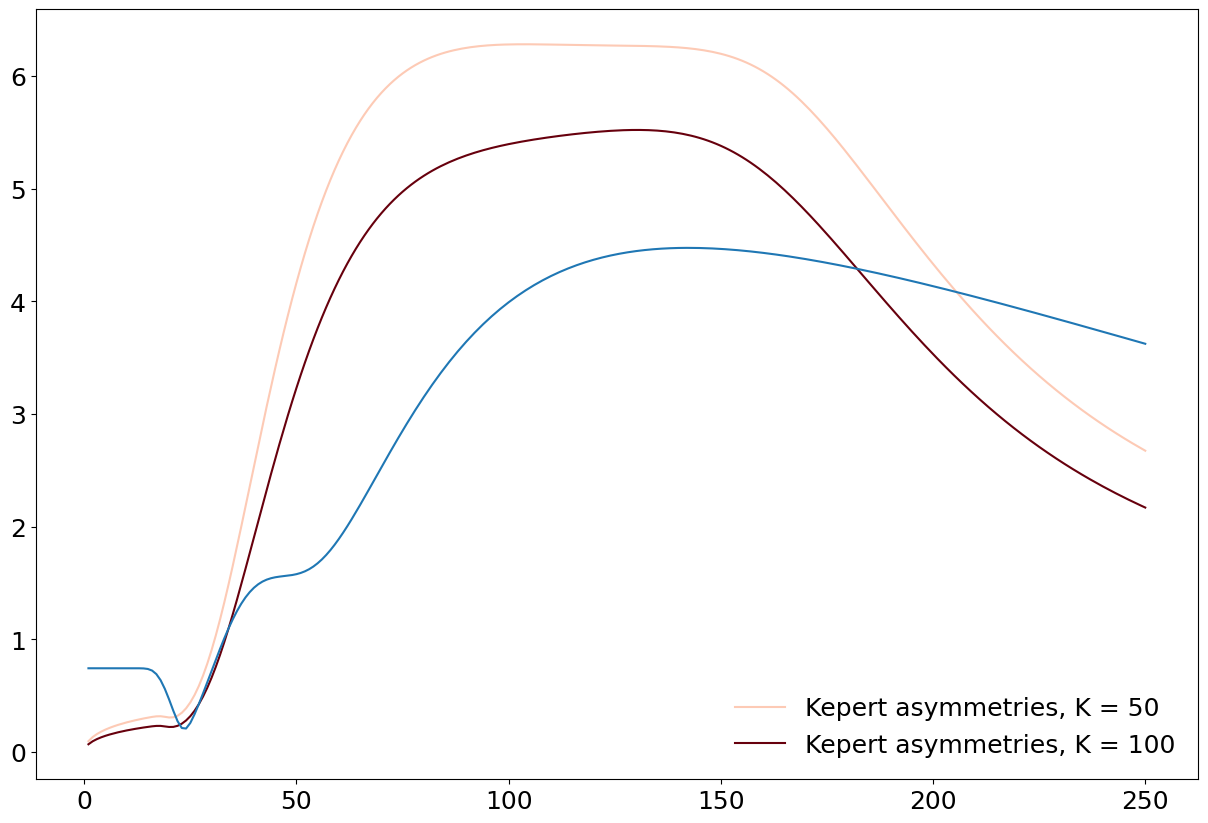

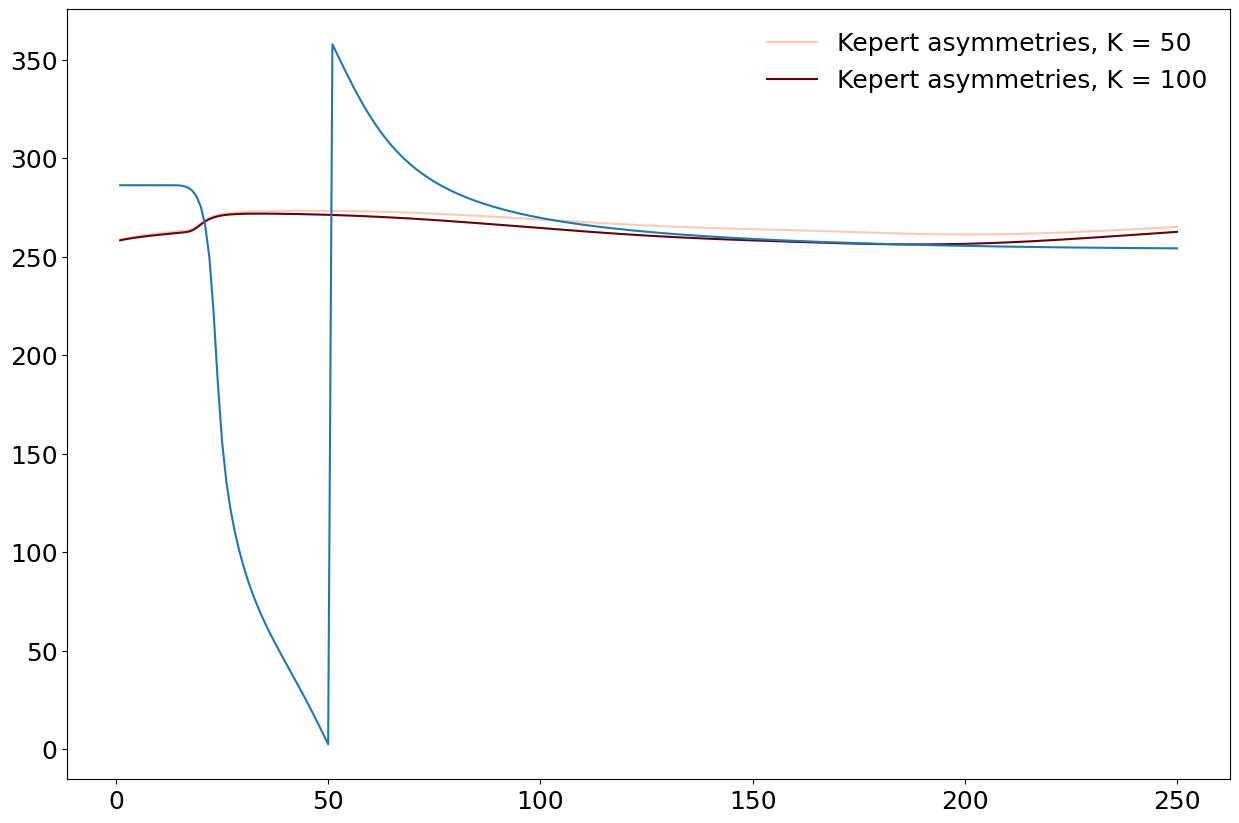

In [18]:
# Kepert asymmetry profiles
for i, K in enumerate(Ks):
    plt.plot(xs / 1000, AKS[K], c=colors[i], label='Kepert asymmetries, K = {}'.format(K))
plt.plot(xs / 1000, ACN)
plt.legend(frameon=False)
plt.show()

# Kepert asymmetry profiles
for i, K in enumerate(Ks):
    plt.plot(xs / 1000,  np.rad2deg(PKS[K]), c=colors[i], label='Kepert asymmetries, K = {}'.format(K))
plt.plot(xs / 1000, np.rad2deg(PHS))
plt.legend(frameon=False)

In [19]:
### Est-ce que je peux déterminer c1 et c2 indépendamment de C et K, en utilisant la phase du maximum d'asymétrie ? 
### L'idéal serait d'avoir une formule analytique sur c1 / c2, en utilisant par exemple une convention c1 ** 2 + c2 ** 2 = 1
### Vérifier déjà que je fitte correctement phi et c sur le modèle et sur le SAR

#### 3) Impose the ratio c1/c2, with arbitrary C, and varying c2 and K

In [20]:
# c1s = [0.1, 0.2, 0.3, 0.4, 0.5]
c2s = [1.0, 2.0]
# c2s = [0.2, 0.3]
c2s = [0.7, 0.8, 0.9]
C   = 1.5e-3            # fixed
Ks  = [50, 100, 150]

In [21]:
import itertools
AKS      = {key: None for key in list(itertools.product(Ks, c2s))}
PKS      = {key: None for key in list(itertools.product(Ks, c2s))}
KEP_POLS = {key: None for key in list(itertools.product(Ks, c2s))}
for K in tqdm(Ks):
    for c2 in tqdm(c2s):
        c1                 = c2 * c1_c2
        aks, pks, kep_pol  = get_kepert_asymmetries(THs, Rs, ths, rs, Vs, K, C, c1, c2, fcr, z_ref, h, xs)
        AKS[(K, c2)]       = aks
        PKS[(K, c2)]       = pks
        KEP_POLS[(K, c2)]  = kep_pol

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

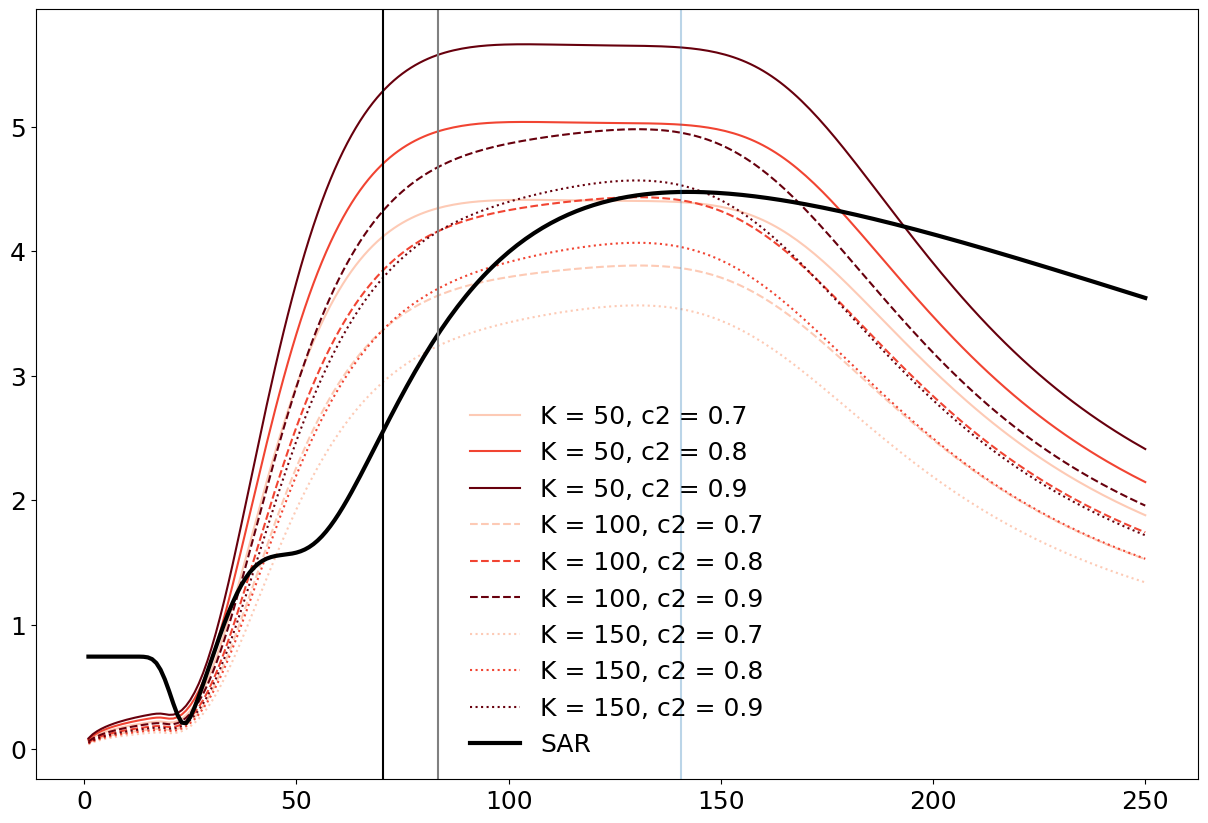

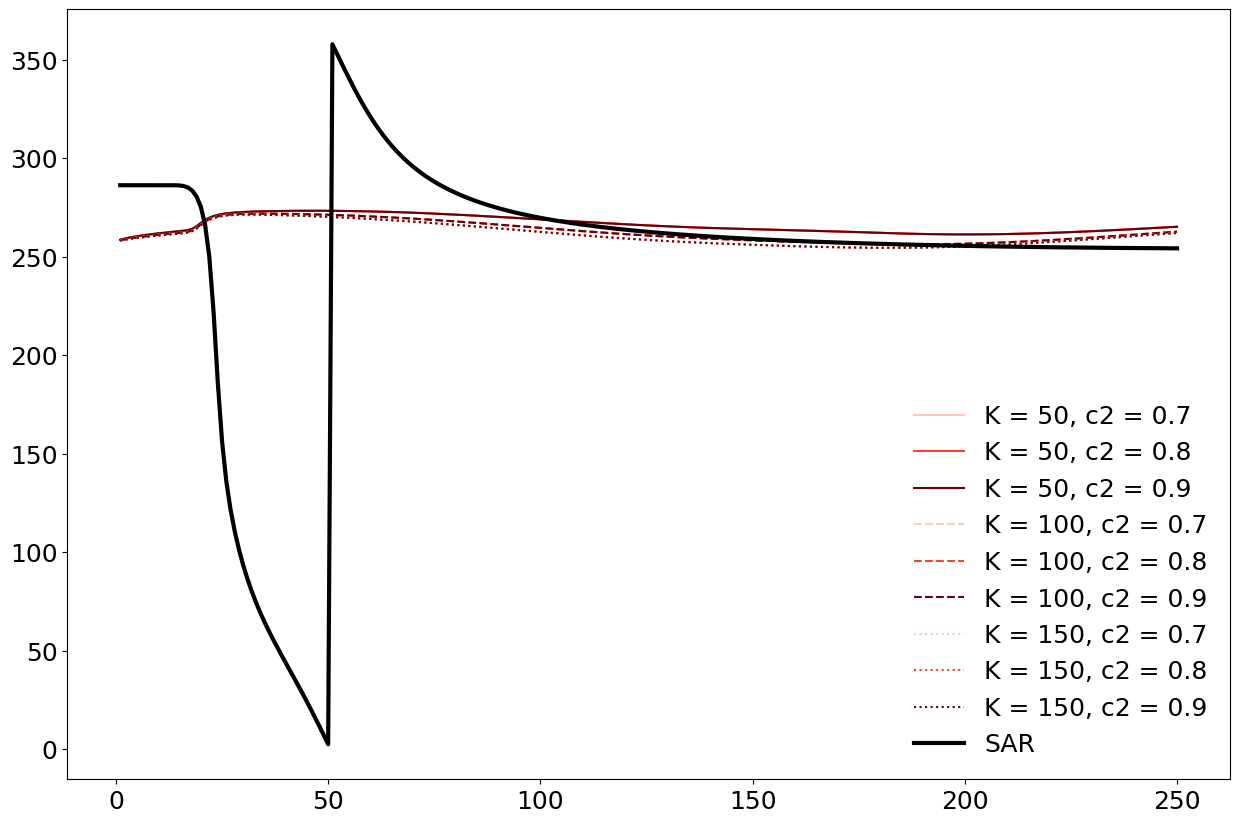

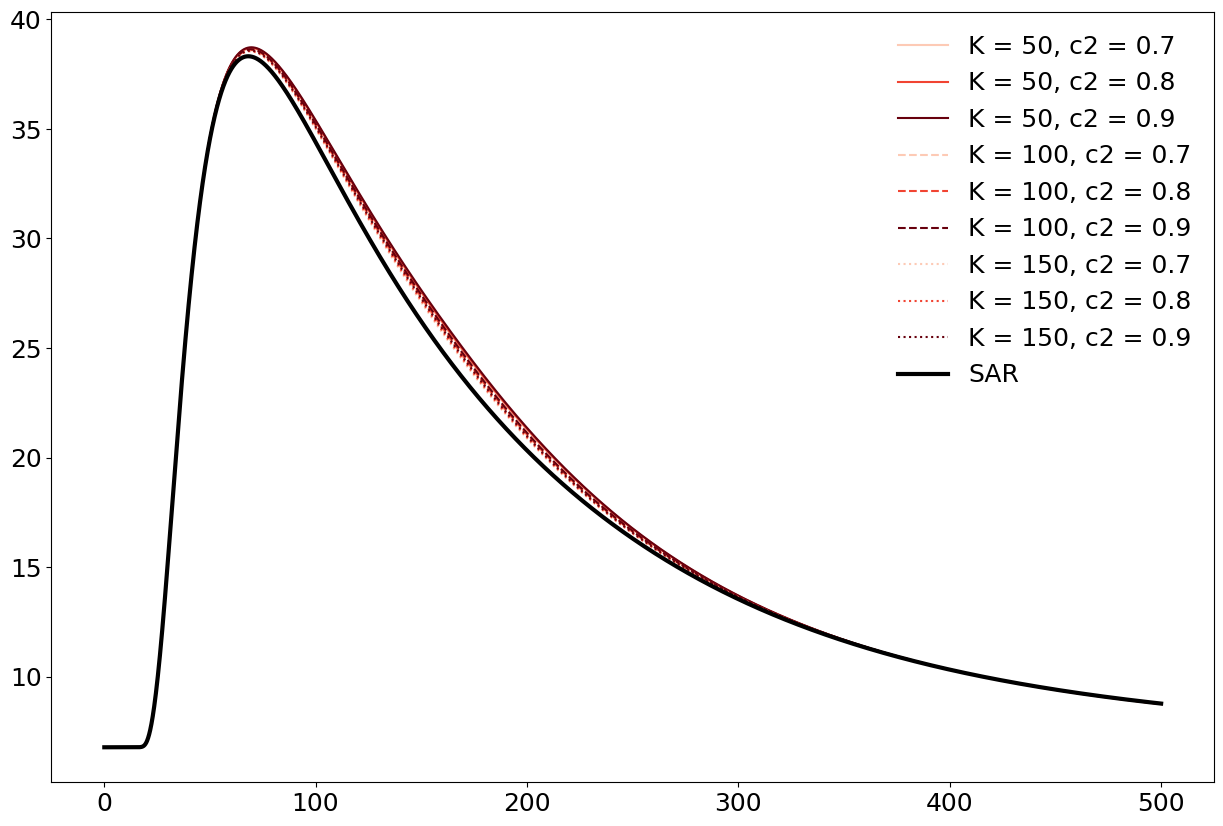

In [22]:
ltsls = ['solid', 'dashed', 'dotted']
clrs  = truncated_Reds(np.linspace(0, 1, len(c2s)))

for iK, K in enumerate(Ks):
    for ic2, c2 in enumerate(c2s):
        plt.plot(xs / 1000, AKS[(K, c2)], c=clrs[ic2], label='K = {}, c2 = {}'.format(K, c2), linestyle=ltsls[K // 50 - 1])
plt.plot(xs / 1000, ACN, c='k', linewidth=3, label='SAR')
plt.axvline(rmx / 1000,        c='k')
plt.axvline(ds.rps / 1000,     c='gray')
plt.axvline(2 * rmx / 1000,    c='tab:blue', alpha=0.3)
plt.legend(frameon=False)
plt.show()

for iK, K in enumerate(Ks):
    for ic2, c2 in enumerate(c2s):
        plt.plot(xs / 1000,  np.rad2deg(PKS[(K, c2)]), c=clrs[ic2], label='K = {}, c2 = {}'.format(K, c2), linestyle=ltsls[K // 50 - 1])
plt.plot(xs / 1000, np.rad2deg(PHS), c='k', linewidth=3, label='SAR')
plt.legend(frameon=False)
plt.show()

for iK, K in enumerate(Ks):
    for ic2, c2 in enumerate(c2s):
        plt.plot(rs / 1000,  KEP_POLS[(K, c2)].wind_speed.mean(dim='theta'), c=clrs[ic2], label='K = {}, c2 = {}'.format(K, c2), linestyle=ltsls[K // 50 - 1])
plt.plot(rs / 1000, Vs[0, :], c='k', linewidth=3, label='SAR')
plt.legend(frameon=False)

#### 4) Same with other c2 and K combinations

In [23]:
# c1s = [0.1, 0.2, 0.3, 0.4, 0.5]
# c2s = [1.0, 2.0]
# c2s = [0.2, 0.3]
c2s = [0.5, 0.6, 0.7]
C   = 1.5e-3            # fixed
Ks  = [10, 25, 50]

In [24]:
import itertools
AKS      = {key: None for key in list(itertools.product(Ks, c2s))}
PKS      = {key: None for key in list(itertools.product(Ks, c2s))}
KEP_POLS = {key: None for key in list(itertools.product(Ks, c2s))}
for K in tqdm(Ks):
    for c2 in tqdm(c2s):
        c1                 = c2 * c1_c2
        aks, pks, kep_pol  = get_kepert_asymmetries(THs, Rs, ths, rs, Vs, K, C, c1, c2, fcr, z_ref, h, xs)
        AKS[(K, c2)]       = aks
        PKS[(K, c2)]       = pks
        KEP_POLS[(K, c2)]  = kep_pol

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

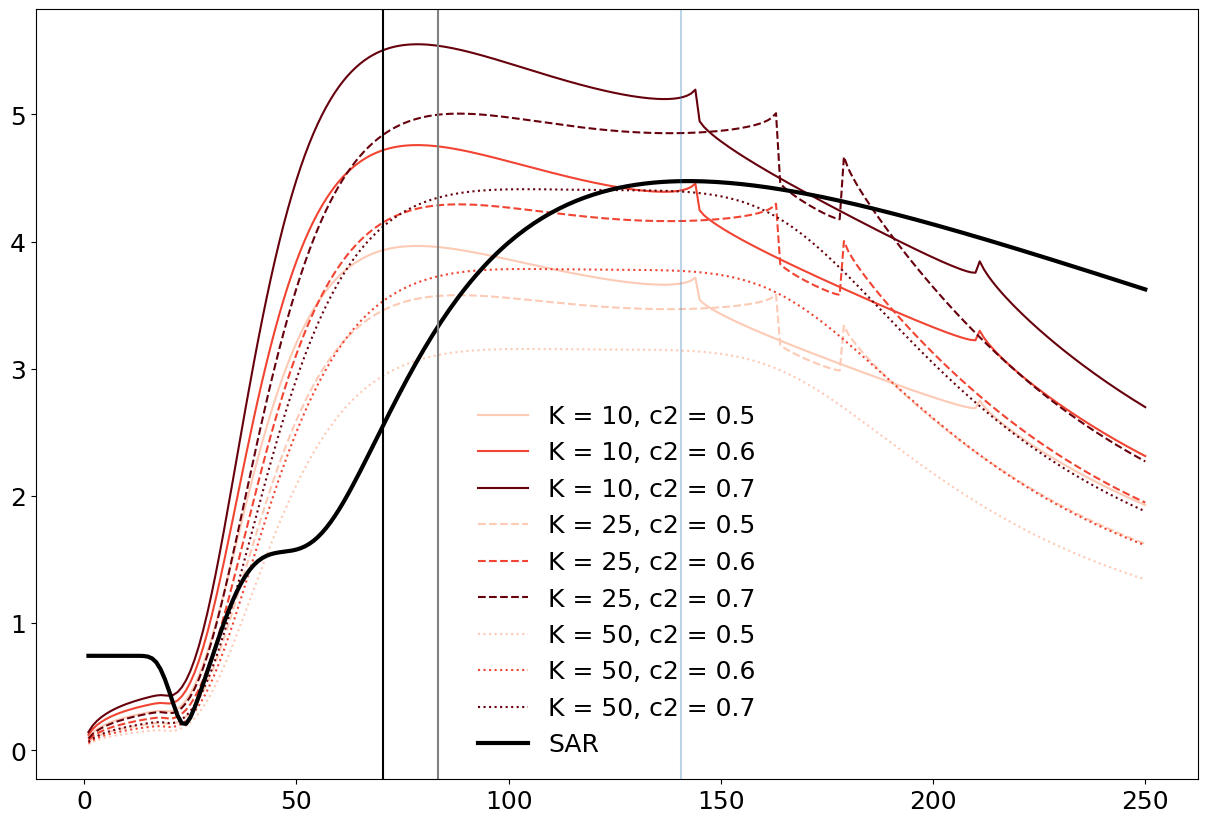

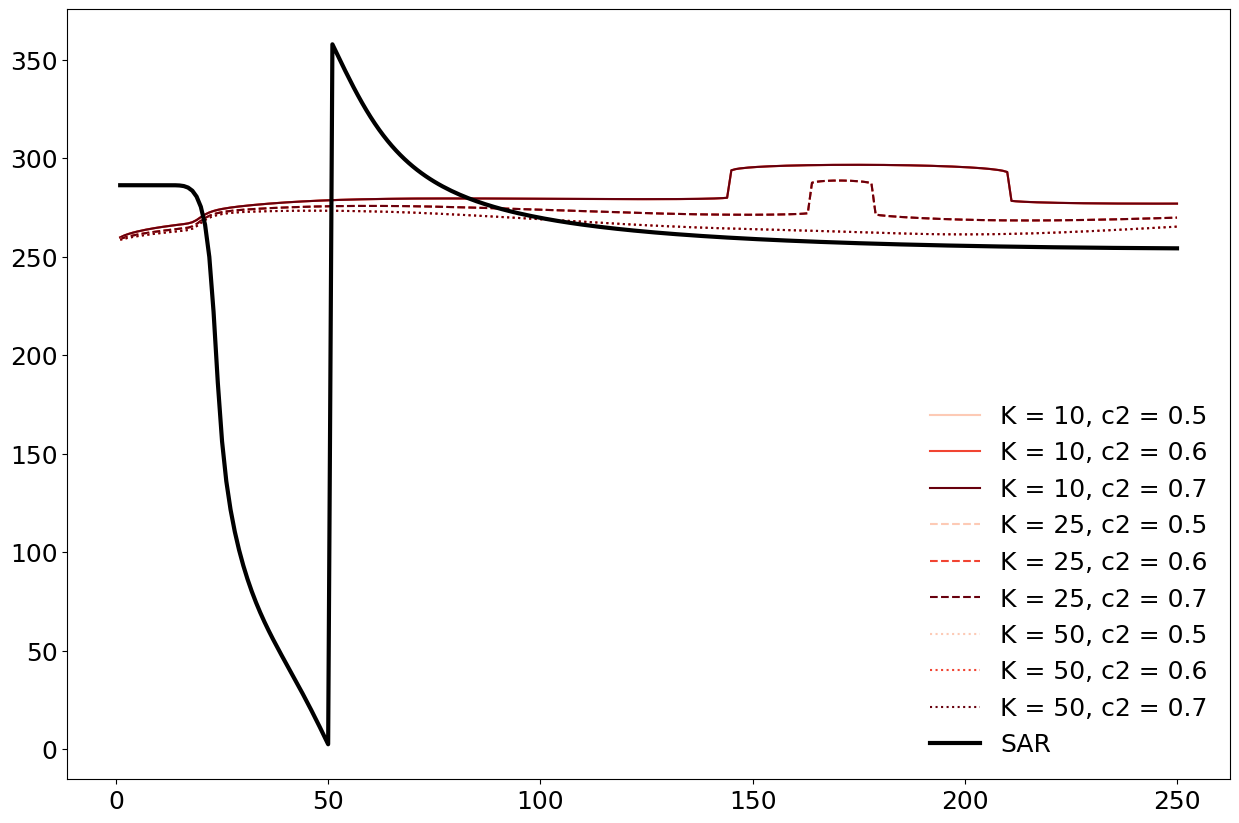

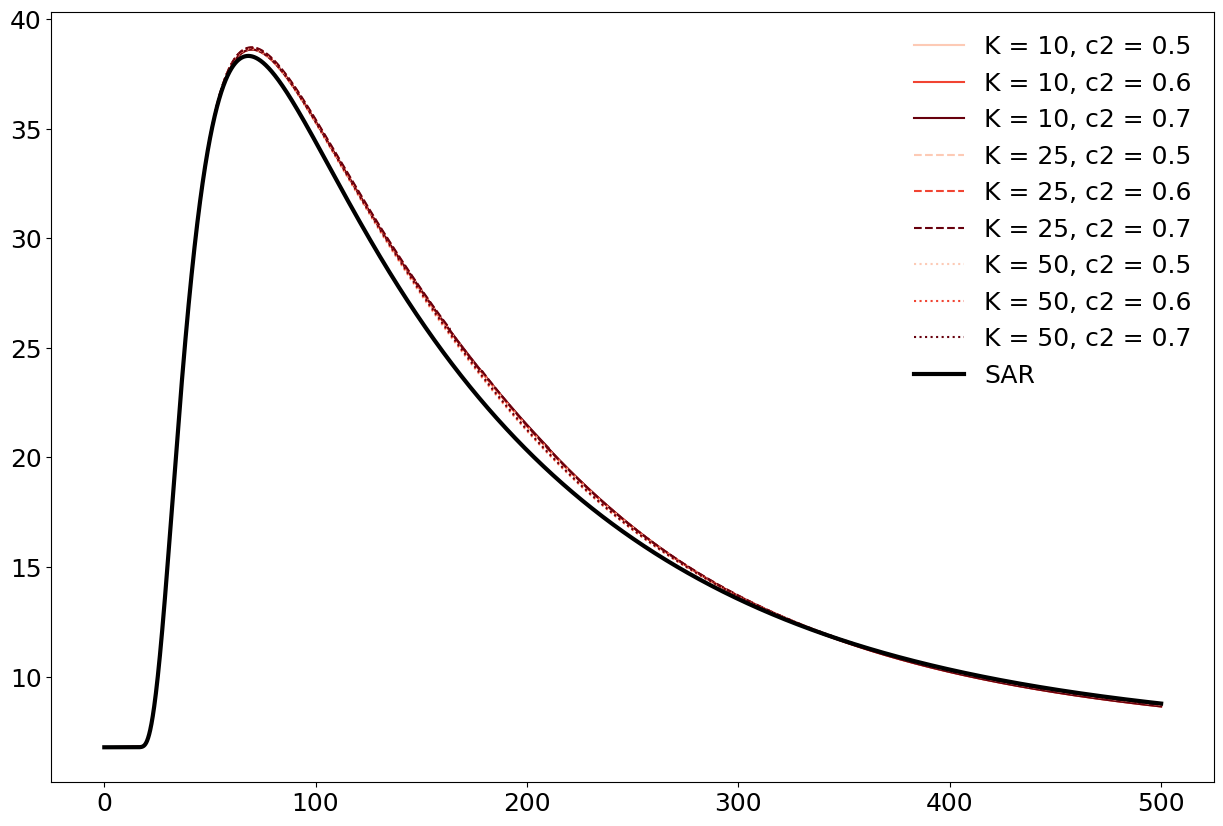

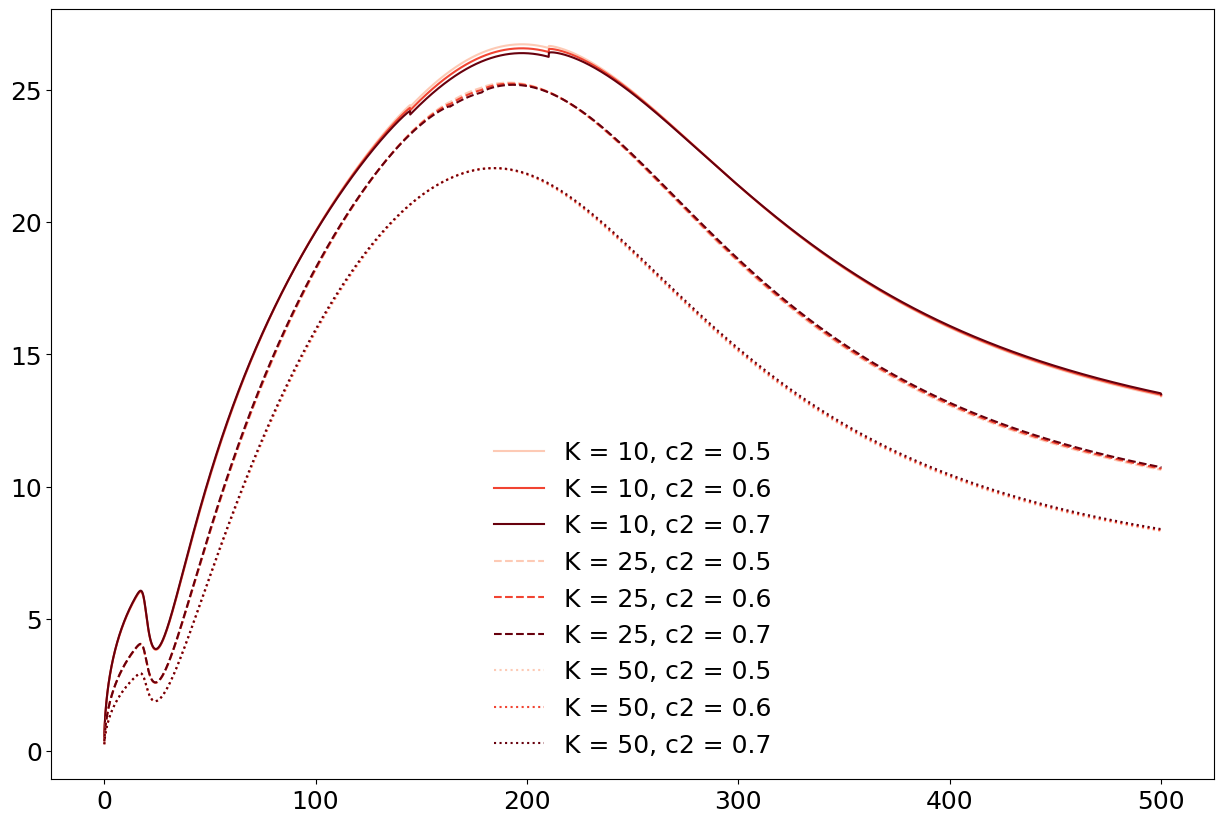

In [25]:
ltsls = ['solid', 'dashed', 'dotted']
clrs  = truncated_Reds(np.linspace(0, 1, len(c2s)))

for iK, K in enumerate(Ks):
    for ic2, c2 in enumerate(c2s):
        plt.plot(xs / 1000, AKS[(K, c2)], c=clrs[ic2], label='K = {}, c2 = {}'.format(K, c2), linestyle=ltsls[K // 25])
plt.plot(xs / 1000, ACN, c='k', linewidth=3, label='SAR')
plt.axvline(rmx / 1000,        c='k')
plt.axvline(ds.rps / 1000,     c='gray')
plt.axvline(2 * rmx / 1000,    c='tab:blue', alpha=0.3)
plt.legend(frameon=False)
plt.show()

for iK, K in enumerate(Ks):
    for ic2, c2 in enumerate(c2s):
        plt.plot(xs / 1000,  np.rad2deg(PKS[(K, c2)]), c=clrs[ic2], label='K = {}, c2 = {}'.format(K, c2), linestyle=ltsls[K // 25])
plt.plot(xs / 1000, np.rad2deg(PHS), c='k', linewidth=3, label='SAR')
plt.legend(frameon=False)
plt.show()

for iK, K in enumerate(Ks):
    for ic2, c2 in enumerate(c2s):
        plt.plot(rs / 1000,  KEP_POLS[(K, c2)].wind_speed.mean(dim='theta'), c=clrs[ic2], label='K = {}, c2 = {}'.format(K, c2), linestyle=ltsls[K // 25])
plt.plot(rs / 1000, Vs[0, :], c='k', linewidth=3, label='SAR')
plt.legend(frameon=False)
plt.show()

for iK, K in enumerate(Ks):
    for ic2, c2 in enumerate(c2s):
        plt.plot(rs / 1000,  np.rad2deg(np.arctan(abs(KEP_POLS[(K, c2)].rad_wind) / abs(KEP_POLS[(K, c2)].tan_wind))).mean(dim='theta'), c=clrs[ic2], label='K = {}, c2 = {}'.format(K, c2), linestyle=ltsls[K // 25])
plt.legend(frameon=False)

The below plots show that there is really no difference in terms of wind speed between the different combinations that match the asymetry at 2Rmax

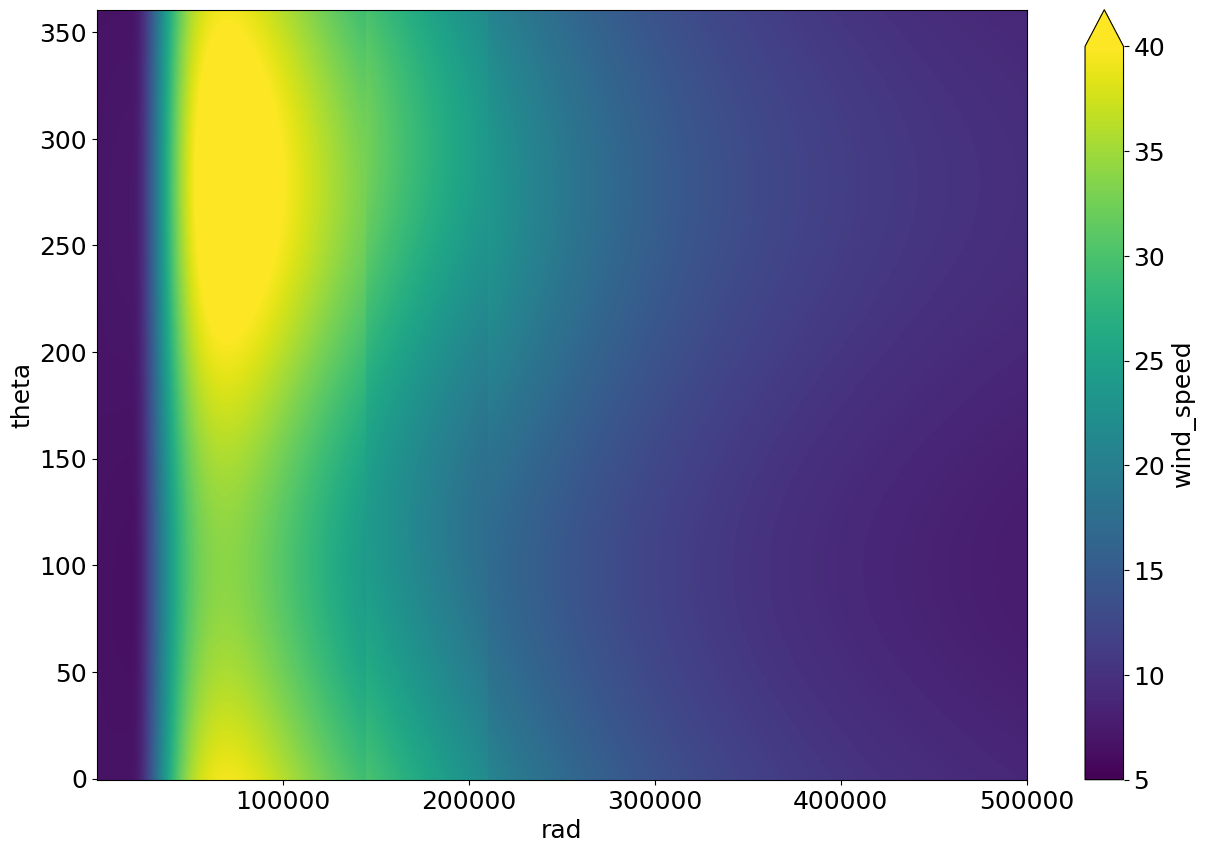

In [26]:
KEP_POLS[(10, 0.6)].wind_speed.plot(vmin=5, vmax=40)

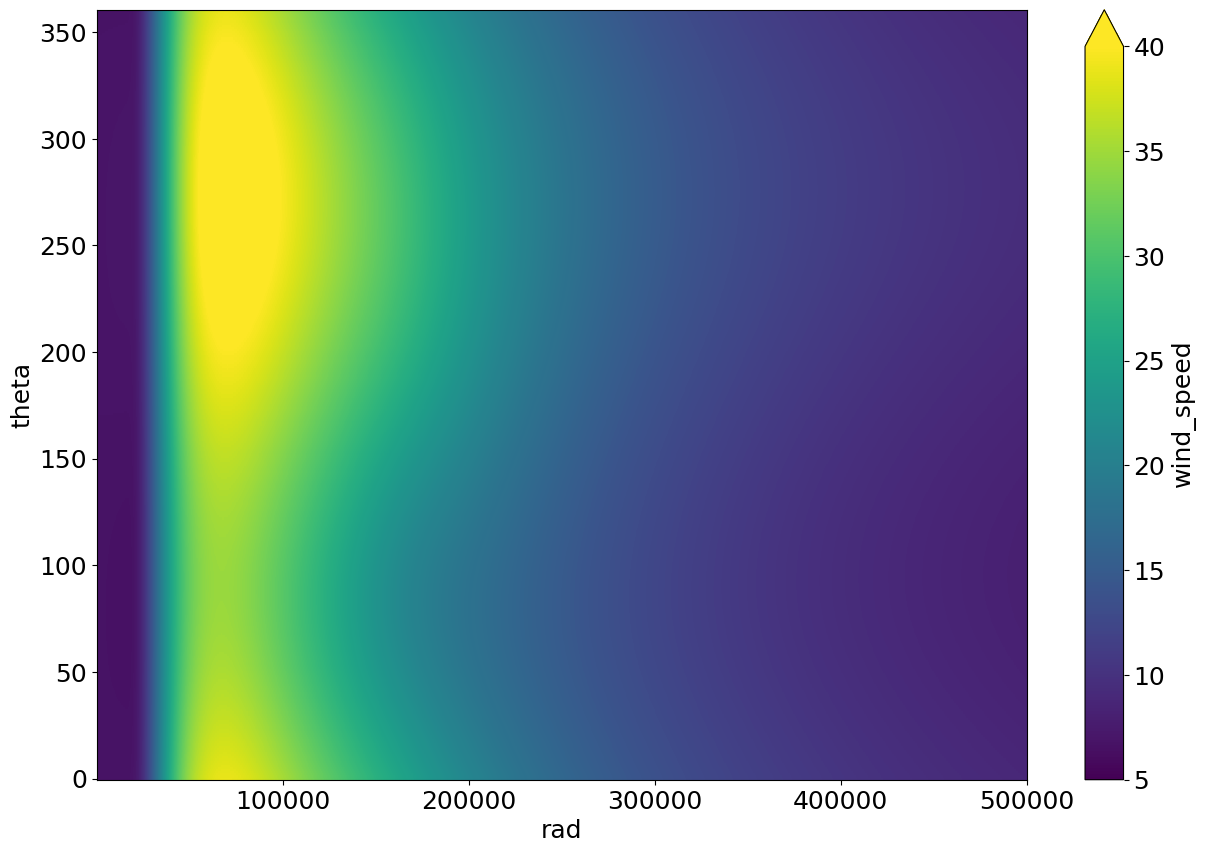

In [27]:
KEP_POLS[(50, 0.7)].wind_speed.plot(vmin=5, vmax=40)

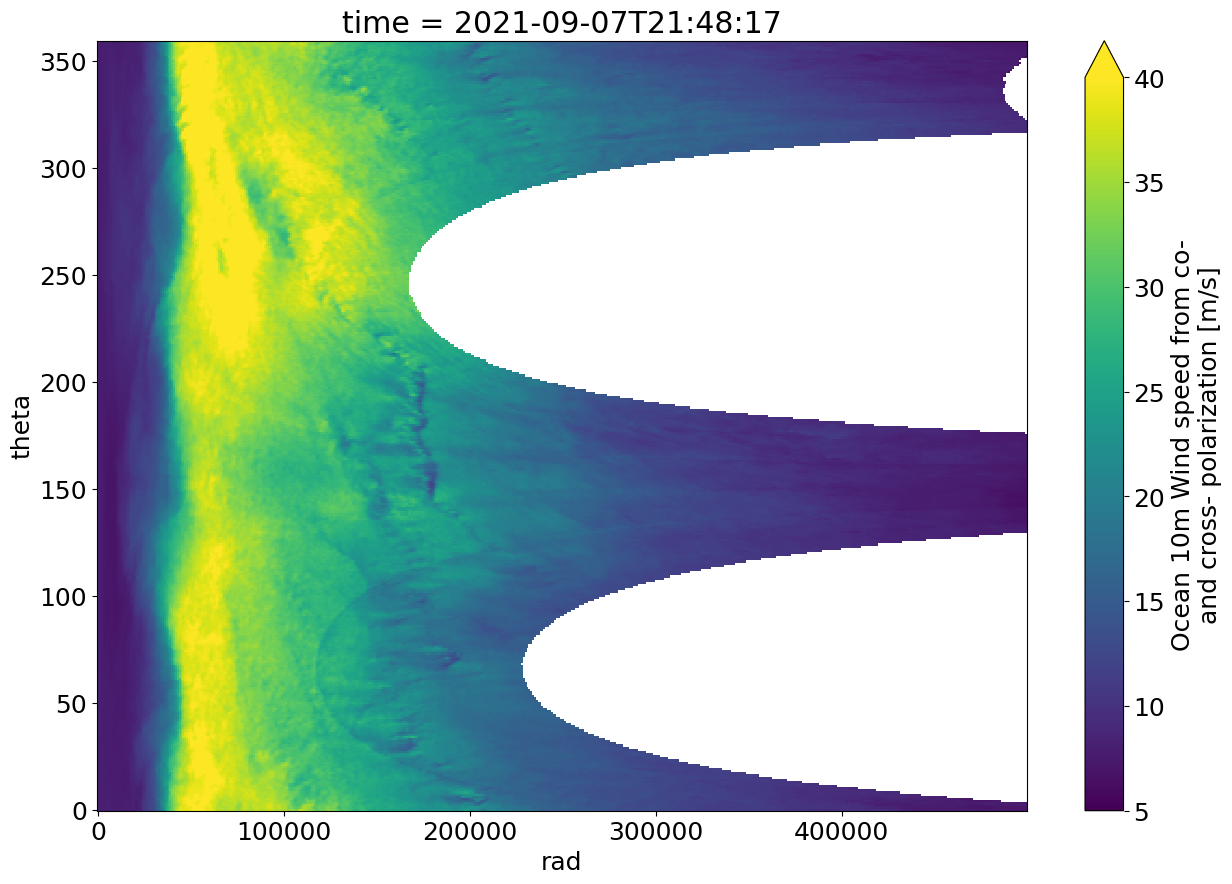

In [28]:
dsp.wind_speed.transpose().plot(vmin=5, vmax=40)

The below plots show that the wiggles really come from locations where I < V/r (I reased some cells so the cells might not work; if so, then you'll have to trust me).

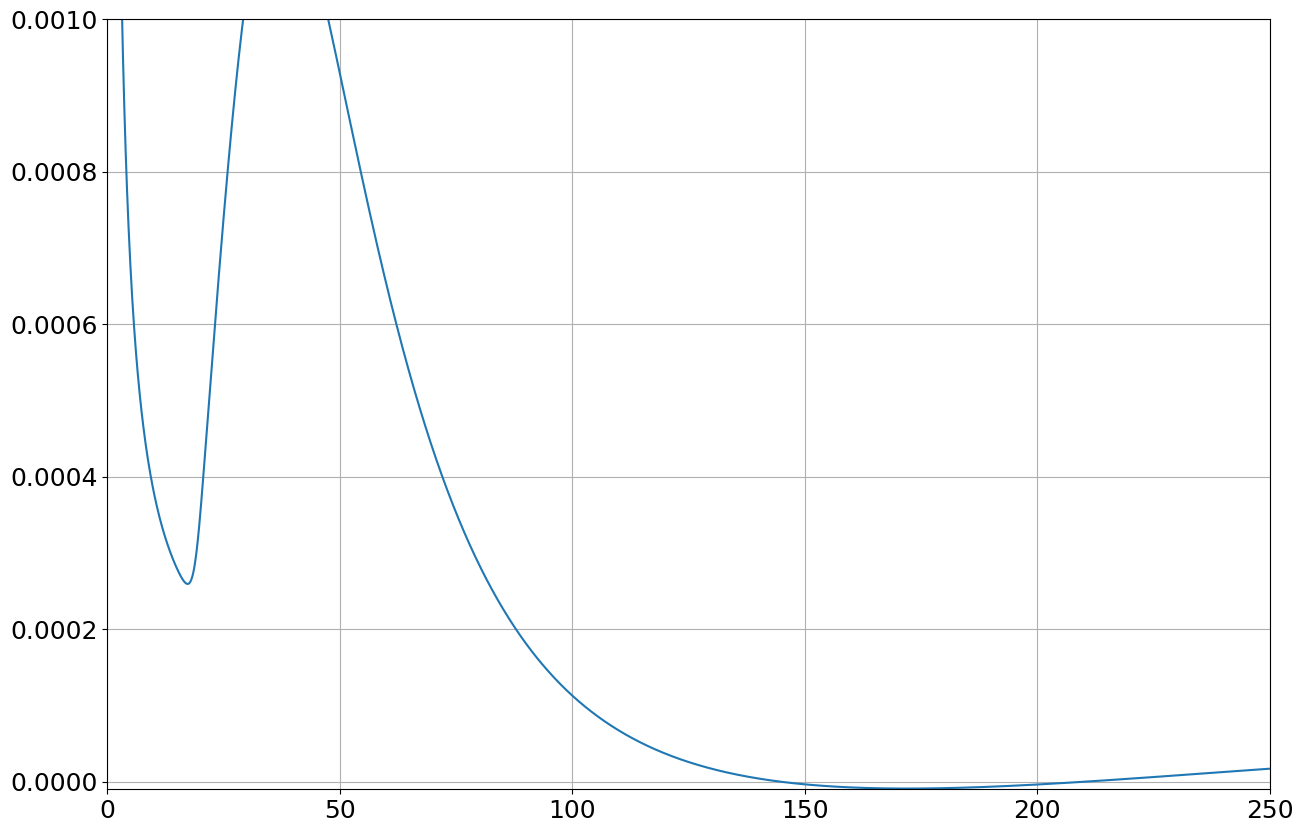

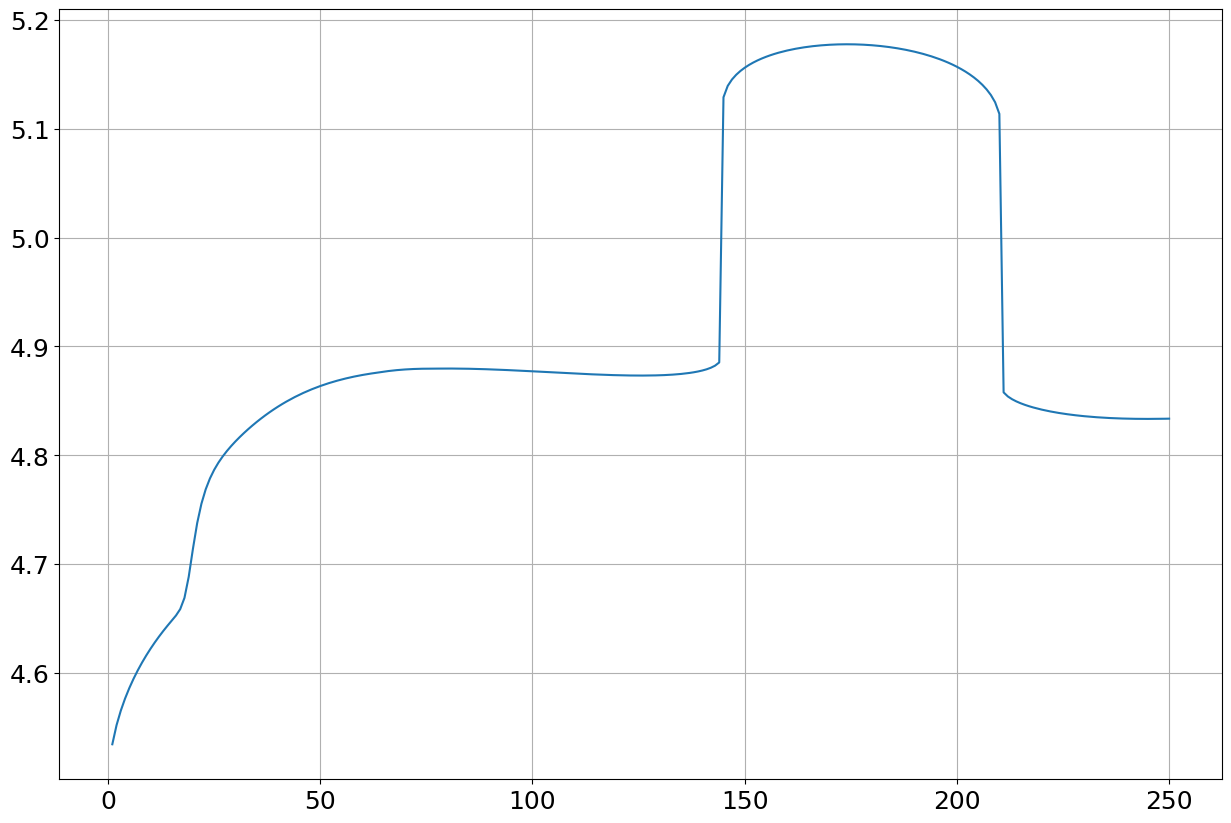

In [32]:
wrf          = wind_reduction_factor(Rs, Vs, 10, C, fcr) # azimuthal wind
Vs_try       = Vs / wrf

I_Vr = I(Rs, Vs_try, fcr)[0, :] - Vs_try[0, :] / rs

plt.plot(rs / 1000, I_Vr)
plt.grid()
plt.ylim(-0.00001, 0.001)
plt.xlim(0, 250)
plt.show()

plt.plot(xs / 1000, PKS[10, 0.5])
plt.grid()

The below plot compares K25 inflow angle with that of scatterometer

In [33]:
### Compute the scatterometer inflow angle

# 07 September
# Metop-A vers 23:00: OK
# Metop-B vers minuit
# Metop-C vers 14:00: OK

# Open data
metopa = xr.open_dataset('/home/arthur/data/scatterometer/samples/ascat_20210907_225400_metopa_77247_eps_o_coa_3202_ovw.l2.nc')
metopa = metopa.isel(NUMCELLS=slice(0, 40), NUMROWS=slice(100, 250))

# metopa.wind_speed.plot(cmap=cwnd, norm=normalizer)

# Get center position from IBTrACS
ds_ibt                = xr.open_dataset('/home/arthur/data/tropical_cyclones/ibtracs/24032025/IBTrACS.ALL.v04r01.nc')[['usa_lon', 'usa_lat', 'usa_atcf_id']]
ds_ibt['usa_atcf_id'] = ds_ibt['usa_atcf_id'].astype(str, copy=False) 
dsi                   = ds_ibt.where(ds_ibt.usa_atcf_id == ds.id.item().upper(), drop=True).isel(storm=0)
dsi_interp            = dsi.assign_coords({'date_time': dsi['time']}).dropna(dim='date_time', subset=['usa_lat'])[['usa_lon', 'usa_lat']].drop_indexes('date_time').interp(date_time=metopa.time.mean())
lon_cen, lat_cen      = float(dsi_interp.usa_lon), float(dsi_interp.usa_lat)

from pyproj import CRS, Geod

lons        = np.array(metopa.lon)
lats        = np.array(metopa.lat)

lons_center = np.ones_like(lons) * lon_cen
lats_center = np.ones_like(lats) * lat_cen

geod_wgs84        = CRS("epsg:4326").get_geod()
forward_az, _, dr = geod_wgs84.inv(lons_center, lats_center, lons, lats)

def get_polar_theta(forward_az):
    '''INPUT: forward_az: 0° is North, 90° is East;
    OUTPUT: theta: 0° is East, 90° is North'''
    theta = (90 - forward_az) % 360 # 0° is North, 90° is East
    return theta

th = get_polar_theta(forward_az) # r is dr

# metopa['radial_wind']     = - metopa.wind_speed * np.sin(np.deg2rad((2 * np.pi - metopa.wind_dir) - th))
# metopa['tangential_wind'] =   metopa.wind_speed * np.cos(np.deg2rad((2 * np.pi - metopa.wind_dir) - th))

# metopa['radial_wind']     = - metopa.wind_speed * np.sin(np.deg2rad( - metopa.wind_dir - th))
# metopa['tangential_wind'] =   metopa.wind_speed * np.cos(np.deg2rad( - metopa.wind_dir - th))

metopa['radial_wind']     = metopa.wind_speed * np.sin(np.deg2rad(metopa.wind_dir + th))
metopa['tangential_wind'] = metopa.wind_speed * np.cos(np.deg2rad(metopa.wind_dir + th))

# Interpolate on reference grid
r_ref        = np.linspace(0, 500, int((500 // 1) + 1))
t_ref        = np.linspace(0, 360, 361)
r_grd, t_grd = np.meshgrid(r_ref, t_ref)
ws_pol       = griddata((dr.flatten() / 1000, th.flatten()), np.array(metopa.wind_speed).flatten(), (r_grd, t_grd), method='linear')
u_pol        = griddata((dr.flatten() / 1000, th.flatten()), np.array(metopa.radial_wind).flatten(), (r_grd, t_grd), method='linear')
v_pol        = griddata((dr.flatten() / 1000, th.flatten()), np.array(metopa.tangential_wind).flatten(), (r_grd, t_grd), method='linear')

# Create xr.Dataset
ds_pol = xr.Dataset(
    data_vars={
        'wind_speed':      (['theta', 'rad'], ws_pol),
        'radial_wind':     (['theta', 'rad'], u_pol),
        'tangential_wind': (['theta', 'rad'], v_pol),
        'lat_cen':         ([], lat_cen),
        'lon_cen':         ([], lon_cen),
    },
    coords={
        'theta': t_ref,
        'rad':   r_ref * 1000
    }
)

#################
### CARTESIAN ###
#################

def pol2cart(r, th):
    x = r * np.cos(th)
    y = r * np.sin(th)
    return x, y

ds_x, ds_y = pol2cart(dr, np.deg2rad(th))

### Interpolate on reference grid
# Create ref. grid, choose resolution
dim_ref      = np.linspace(-500, 500, int((500 // 1 * 2) + 1)) * 1000
x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)
# Interpolate on reference grid
ws_car       = griddata((ds_x.flatten(), ds_y.flatten()), np.array(metopa.wind_speed).flatten(), (x_ref, y_ref), method='linear')
u_car       = griddata((ds_x.flatten(), ds_y.flatten()), np.array(metopa.radial_wind).flatten(), (x_ref, y_ref), method='linear')
v_car       = griddata((ds_x.flatten(), ds_y.flatten()), np.array(metopa.tangential_wind).flatten(), (x_ref, y_ref), method='linear')

#  Create Dataset
ds_car = xr.Dataset(
    data_vars={
        'wind_speed':      (['x', 'y'], ws_car), 
        'radial_wind':     (['x', 'y'], u_car),
        'tangential_wind': (['x', 'y'], v_car),
        'lat_cen':         ([], lat_cen),
        'lon_cen':         ([], lon_cen),
    },
    coords={
        'x': dim_ref,
        'y': dim_ref
    }
)

# Filter the 0 m/s values
ds_pol['wind_speed'] = xr.where(ds_pol['wind_speed'] > 0, ds_pol['wind_speed'], np.nan)
ds_car['wind_speed'] = xr.where(ds_car['wind_speed'] > 0, ds_car['wind_speed'], np.nan)

# Inflow angle
a_sct = np.rad2deg(np.arctan(abs(ds_pol.radial_wind.mean(dim='theta', skipna=True)) / abs(ds_pol.tangential_wind.mean(dim='theta', skipna=True))))

In [38]:
a50 = np.rad2deg(np.arctan(abs(KEP_POLS[50, 0.7].rad_wind) / abs(KEP_POLS[50, 0.7].tan_wind)))
a10 = np.rad2deg(np.arctan(abs(KEP_POLS[10, 0.6].rad_wind) / abs(KEP_POLS[10, 0.6].tan_wind)))

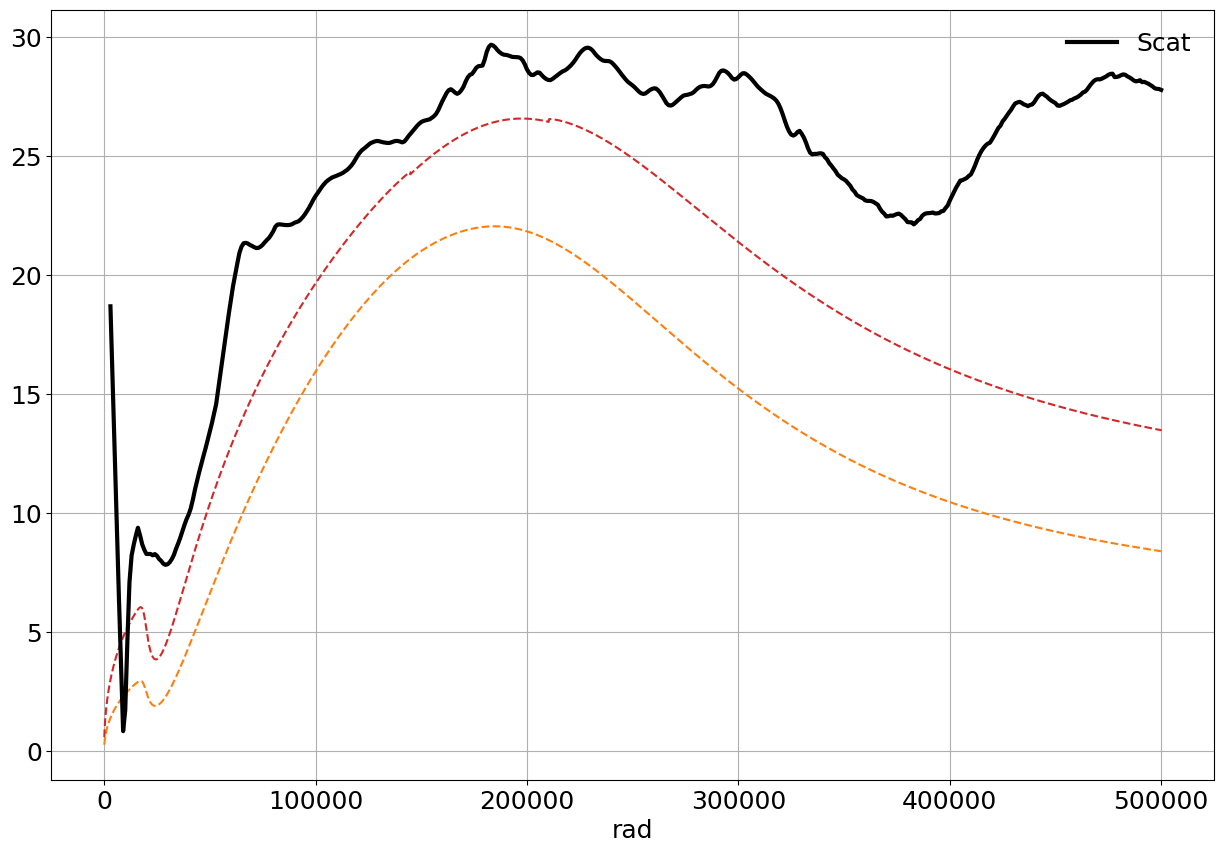

In [39]:
a50.mean(dim='theta').plot(c='tab:orange', linestyle='dashed')
a10.mean(dim='theta').plot(c='tab:red', linestyle='dashed')
a_sct.plot(c='k', linewidth=3, label='Scat') # scatterometer
plt.grid()
plt.legend(frameon=False)

### Calibrating with dropsondes

SAR ==> c1/c2 already determined by the azimuth of the max. surface asymmetry

SAR ==> (C / sqrt(K), c2) pairs already determined by the asymmetry at 2Rmax 

DPs ==> K is determined by the BL height observed in DPs ==> is it enough?

Calibrate the full Kepert's model with the RMSE with the total wind speed. If that doesn't work fine I could also look at the maximum wind speed.

In [40]:
dps_all = glob.glob(PTHS['dps_dir'] + '*.nc')
dp      = xr.open_dataset(dps_all[0])

In [41]:
from pyproj import CRS, Geod

### FUNCTIONS
def get_polar_theta(forward_az):
    '''INPUT: forward_az: 0° is North, 90° is East;
    OUTPUT: theta: 0° is East, 90° is North'''
    theta = (90 - forward_az) % 360 # 0° is North, 90° is East
    return theta

def pol2cart(r, th):
    x = r * np.cos(th)
    y = r * np.sin(th)
    return x, y

def get_new_aircraft_coords_based_on_storm_motion(diwp, storm_dir, storm_speed, time_cen, lon_cen, lat_cen):
    '''storm_dir: usually float(ds.storm_dir_ibt), i.e degrees east of north
    storm_speed: usually float(ds.storm_speed_ibt), i.e m/s
    time_cen: usually ds.time, i.e np.datetime64 indicating the time of the considered center point
    lon_cen, lat_cen: usually float(ds.lon) and float(ds.lat), i.e coordinates of the storm center (degrees East and North)
    '''
    # Temps écoulé depuis le temps d'acquisition SAR
    dt              = diwp.time - time_cen
    diwp['dt_scds'] = xr.DataArray(
        data=np.array(dt.dt.days * 24 * 3600 + dt.dt.seconds),
        dims=['time']
    )
    diwp.dt_scds.attrs['description'] = 'Temps écoulé depuis le temps d acquisition SAR'

    # New longitudes/latitudes after moving x meters to a specified direction
    geod_wgs84            = CRS("epsg:4326").get_geod()
    new_lons, new_lats, _ = geod_wgs84.fwd(lons=diwp.lon, lats=diwp.lat, az=np.ones_like(diwp.lon) * storm_dir, dist=-diwp.dt_scds * storm_speed)
    
    diwp['new_lon']       = xr.DataArray(data=new_lons, dims=['time'])
    diwp['new_lat']       = xr.DataArray(data=new_lats, dims=['time'])
    diwp.new_lon.attrs['description'] = 'longitude of the point after correcting for storm motion'
    diwp.new_lat.attrs['description'] = 'latitude of the point after correcting for storm motion'

    # Compute polar coordinates
    geod_wgs84        = CRS("epsg:4326").get_geod()
    forward_az, _, dr = geod_wgs84.inv(np.ones_like(diwp.lon) * lon_cen, np.ones_like(diwp.lat) * lat_cen, diwp.new_lon, diwp.new_lat)
    th                = get_polar_theta(forward_az) # r is dr
    
    diwp['r']         = xr.DataArray(data=dr, dims=['time'])
    diwp['th']        = xr.DataArray(data=th, dims=['time'])
    diwp.r.attrs['description']  = 'radius of the point after correcting for storm motion'
    diwp.th.attrs['description'] = 'azimuth of the point after correcting for storm motion'

    # Compute cartesian coordinates
    x, y      = pol2cart(dr, np.deg2rad(th))
    diwp['x'] = xr.DataArray(data=x, dims=['time'])
    diwp['y'] = xr.DataArray(data=y, dims=['time'])
    diwp.x.attrs['description'] = 'x of the point after correcting for storm motion'
    diwp.y.attrs['description'] = 'y of the point after correcting for storm motion'

    return diwp

In [42]:
# dsp.wind_speed.transpose().plot(vmin=5, vmax=40, cmap='viridis')
# for file in tqdm(dps_all):
#     dp        = xr.open_dataset(file)
#     dp        = get_new_aircraft_coords_based_on_storm_motion(dp, float(ds.storm_dir_ibt), float(ds.storm_speed_ibt), ds.time, float(ds.lon), float(ds.lat))
#     dp['hws'] = np.sqrt(dp.u_wind ** 2 + dp.v_wind ** 2)
#     plt.scatter(dp.r, dp.th, c=dp.hws, vmin=5, vmax=40, cmap='viridis')

#### 1) Initialize 2 Kepert wind fields

In [43]:
zs           = np.array([10, 110, 210, 310, 510, 1010, 1510, 2010])   # meters

# BL characteristics
z_ref = 10
h     = 1
C     = 1.5e-3            # fixed
K     = 50
c2    = 0.7
c1    = c2 * c1_c2

In [44]:
kep_pol1, kep_car1 = get_z_kepert(THs, Rs, ths, rs, zs, Vs, K, C, c1, c2, fcr, z_ref, h)
kep_pol1, kep_car1 = get_w(kep_pol1, kep_car1, zs)

  0%|          | 0/8 [00:00<?, ?it/s]

Polar dataset created.


  0%|          | 0/8 [00:00<?, ?it/s]

Cartesian dataset created.


  0%|          | 0/8 [00:00<?, ?it/s]

In [45]:
K     = 10
c2    = 0.6
kep_pol2, kep_car2 = get_z_kepert(THs, Rs, ths, rs, zs, Vs, K, C, c1, c2, fcr, z_ref, h)
kep_pol2, kep_car2 = get_w(kep_pol2, kep_car2, zs)

  0%|          | 0/8 [00:00<?, ?it/s]

Polar dataset created.


  0%|          | 0/8 [00:00<?, ?it/s]

Cartesian dataset created.


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

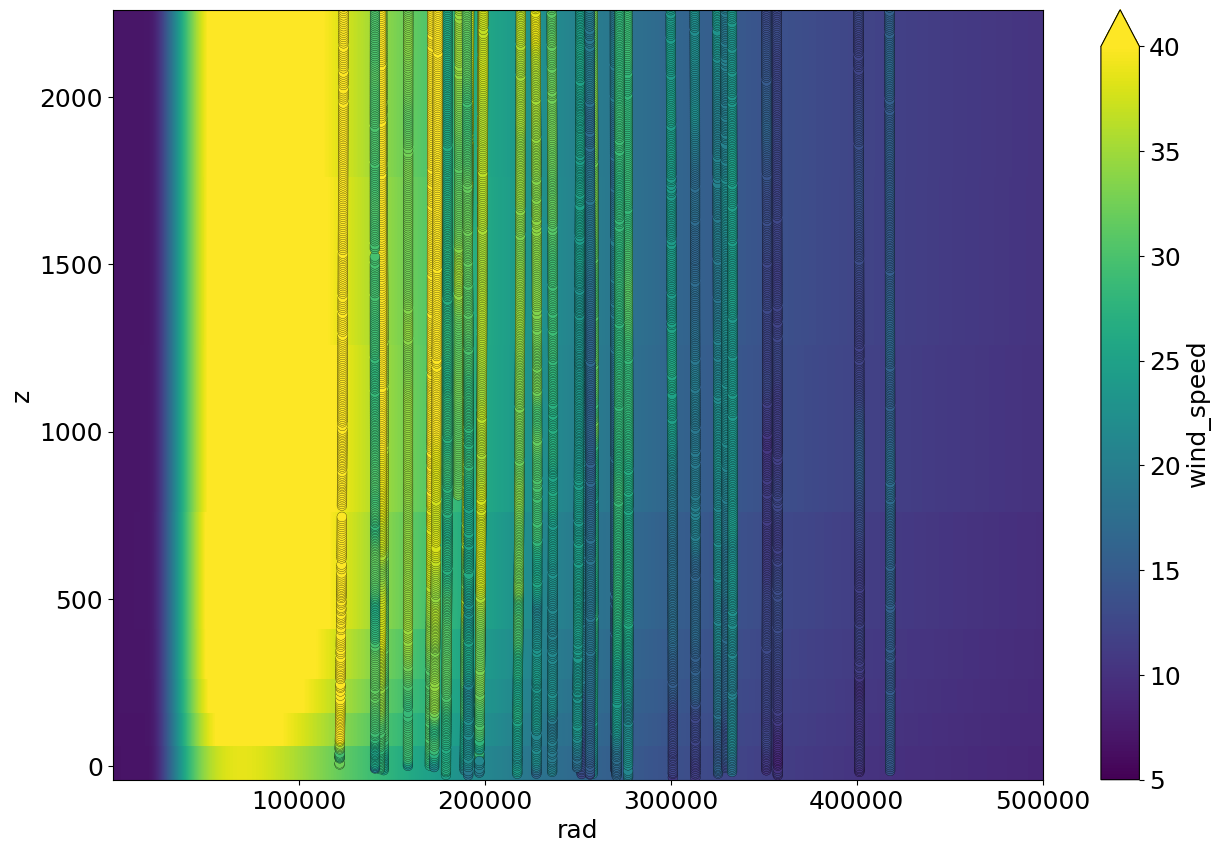

In [46]:
kep_pol1.mean(dim='theta').wind_speed.plot(vmin=5, vmax=40, cmap='viridis')
# dsp.wind_speed.transpose().plot(vmin=5, vmax=40, cmap='viridis')
for file in tqdm(dps_all):
    dp        = xr.open_dataset(file)
    dp        = get_new_aircraft_coords_based_on_storm_motion(dp, float(ds.storm_dir_ibt), float(ds.storm_speed_ibt), ds.time, float(ds.lon), float(ds.lat))
    dp['hws'] = np.sqrt(dp.u_wind ** 2 + dp.v_wind ** 2)
    plt.scatter(dp.r, dp.gpsalt, c=dp.hws, vmin=5, vmax=40, cmap='viridis', edgecolor='black', linewidth=0.2, s=50)

  0%|          | 0/33 [00:00<?, ?it/s]

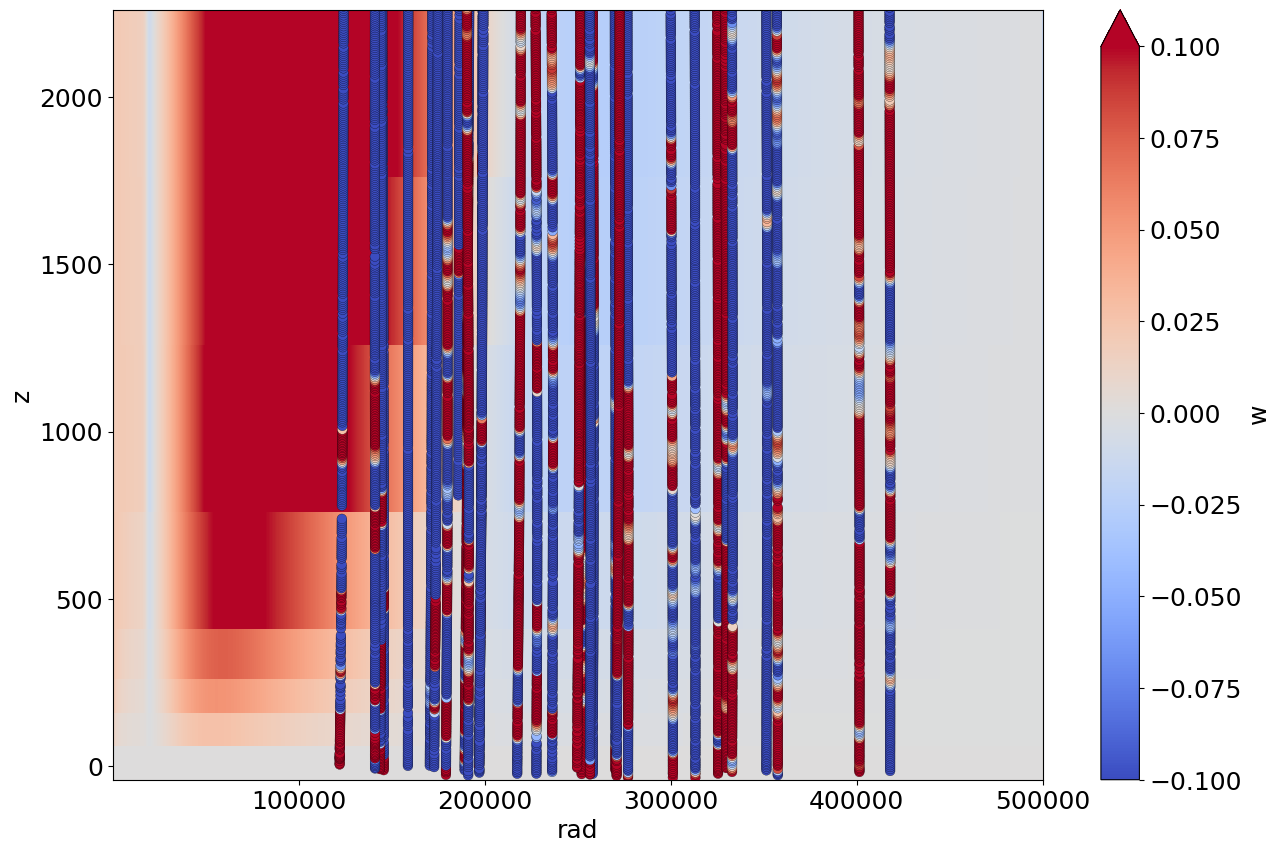

In [47]:
kep_pol1.mean(dim='theta').w.plot(cmap='coolwarm', vmin=-0.1, vmax=0.1)
# dsp.wind_speed.transpose().plot(vmin=5, vmax=40, cmap='viridis')
for file in tqdm(dps_all):
    dp        = xr.open_dataset(file)
    dp        = get_new_aircraft_coords_based_on_storm_motion(dp, float(ds.storm_dir_ibt), float(ds.storm_speed_ibt), ds.time, float(ds.lon), float(ds.lat))
    plt.scatter(dp.r, dp.gpsalt, c=dp.w_wind, cmap='coolwarm', vmin=-0.1, vmax=0.1, edgecolor='black', linewidth=0.2, s=50)

  0%|          | 0/33 [00:00<?, ?it/s]

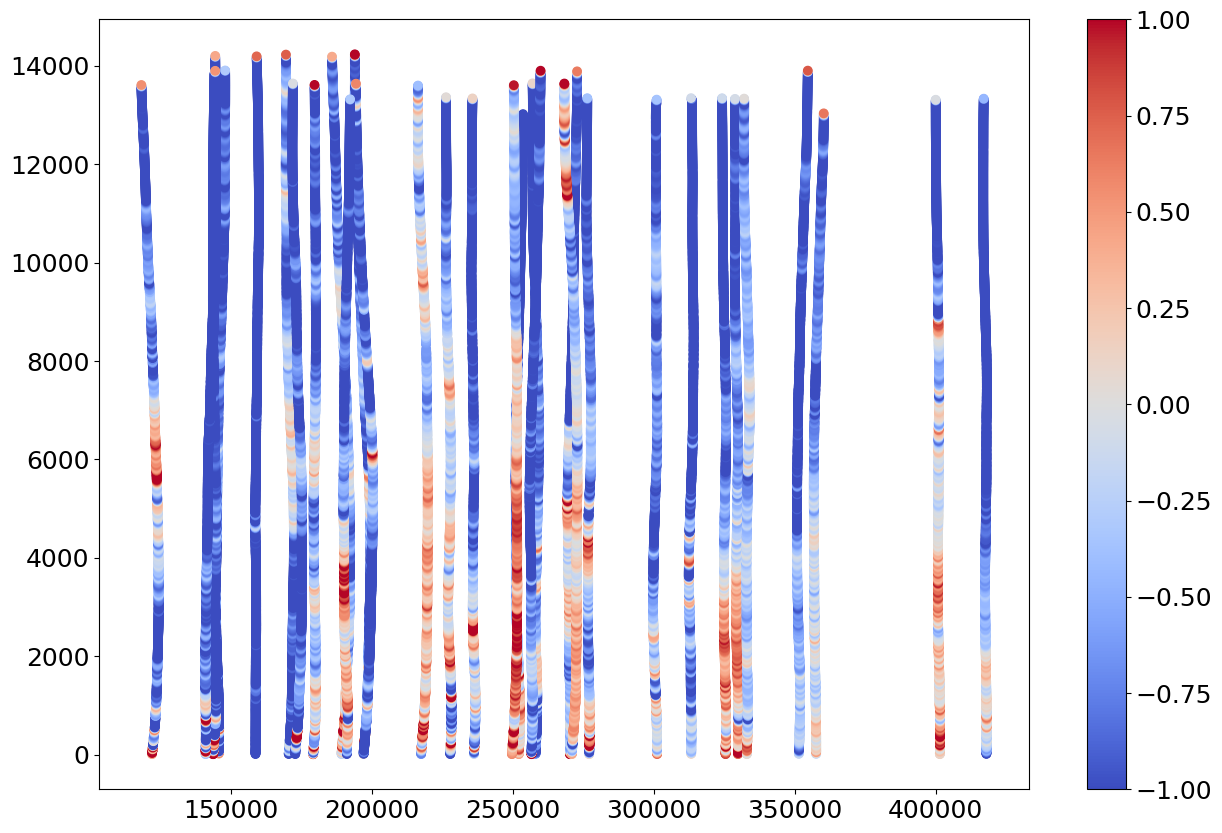

In [48]:
for file in tqdm(dps_all):
    dp        = xr.open_dataset(file)
    dp        = get_new_aircraft_coords_based_on_storm_motion(dp, float(ds.storm_dir_ibt), float(ds.storm_speed_ibt), ds.time, float(ds.lon), float(ds.lat))
    sc        = plt.scatter(dp.r, dp.alt, c=dp.w_wind, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(sc)

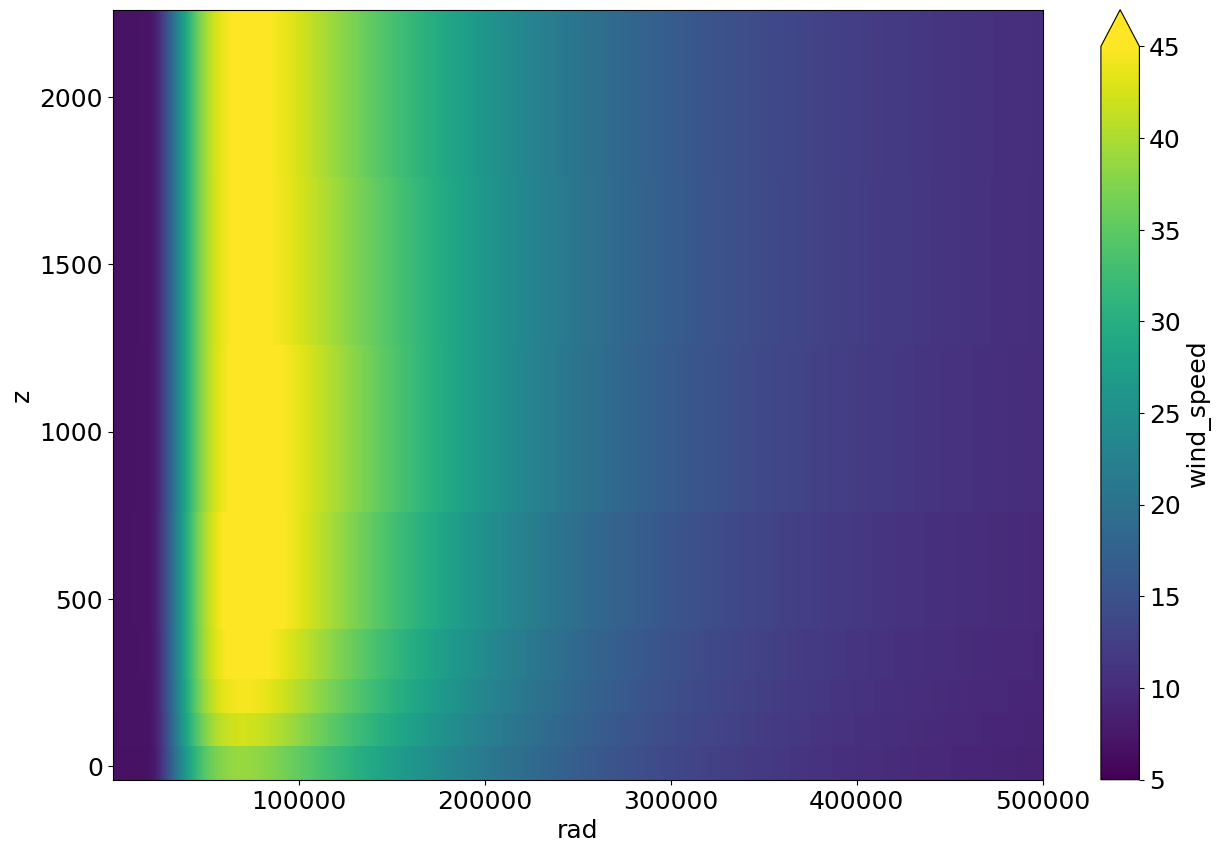

In [49]:
kep_pol1.mean(dim='theta').wind_speed.plot(vmin=5, vmax=45, cmap='viridis')

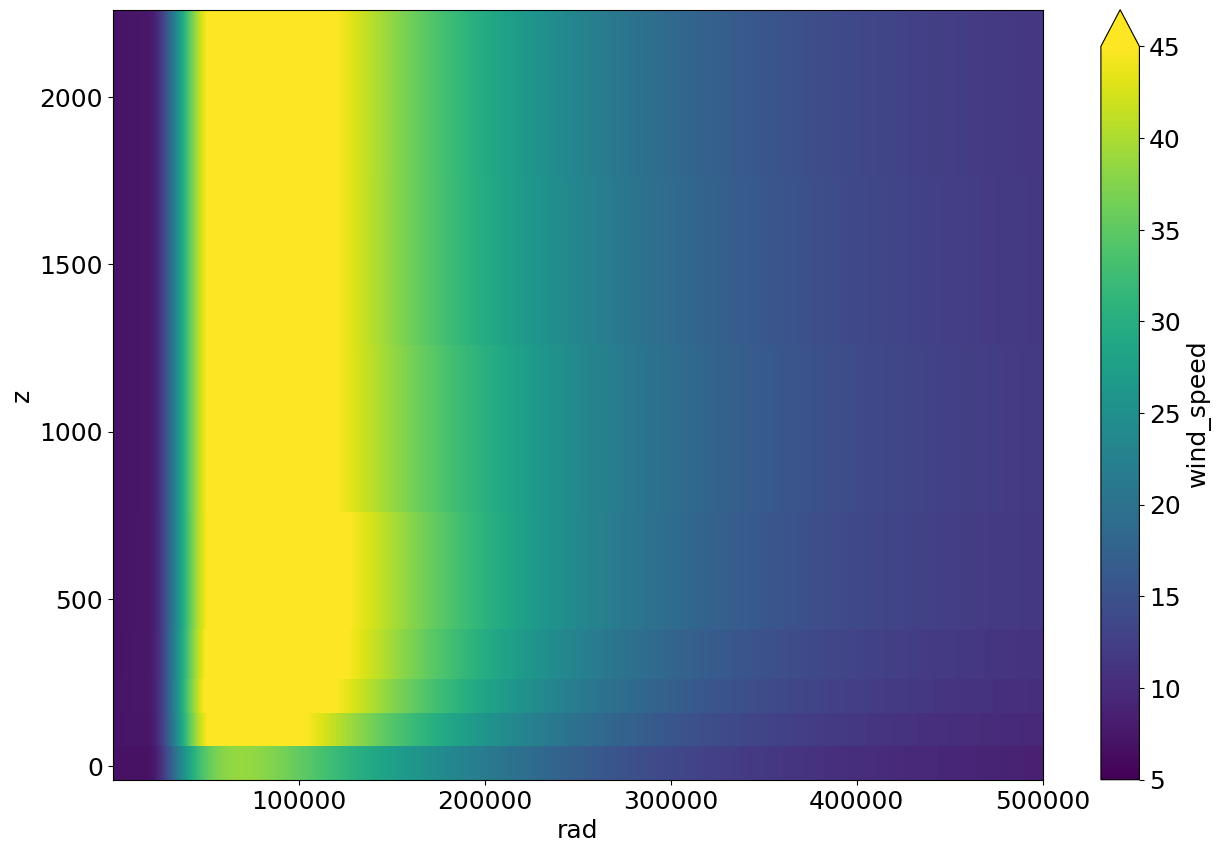

In [50]:
kep_pol2.mean(dim='theta').wind_speed.plot(vmin=5, vmax=45, cmap='viridis')

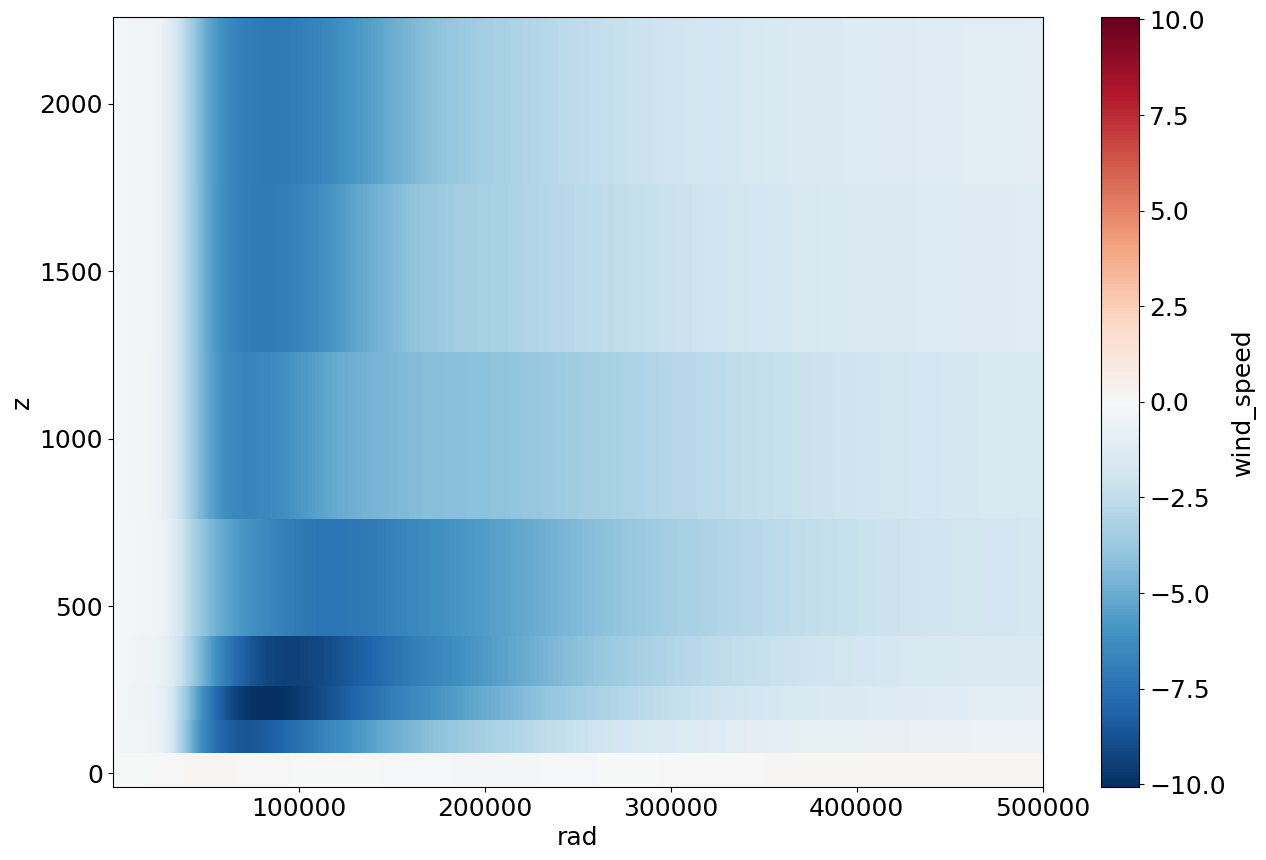

In [51]:
(kep_pol1 - kep_pol2).mean(dim='theta').wind_speed.plot()

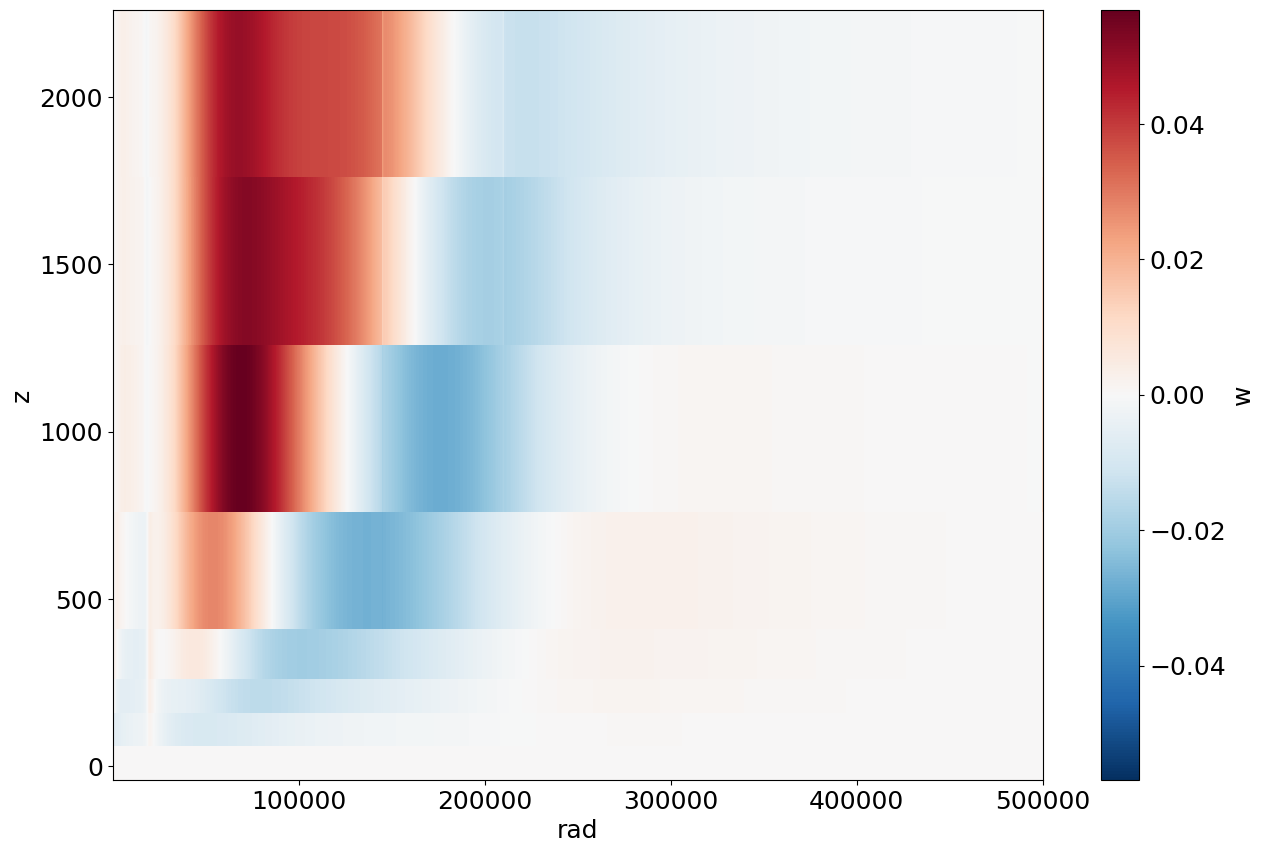

In [52]:
(kep_pol1 - kep_pol2).mean(dim='theta').w.plot()

#### 2) Calibrate K with BL height

Bad idea because it would require being consistent with the BL height definition in the literature

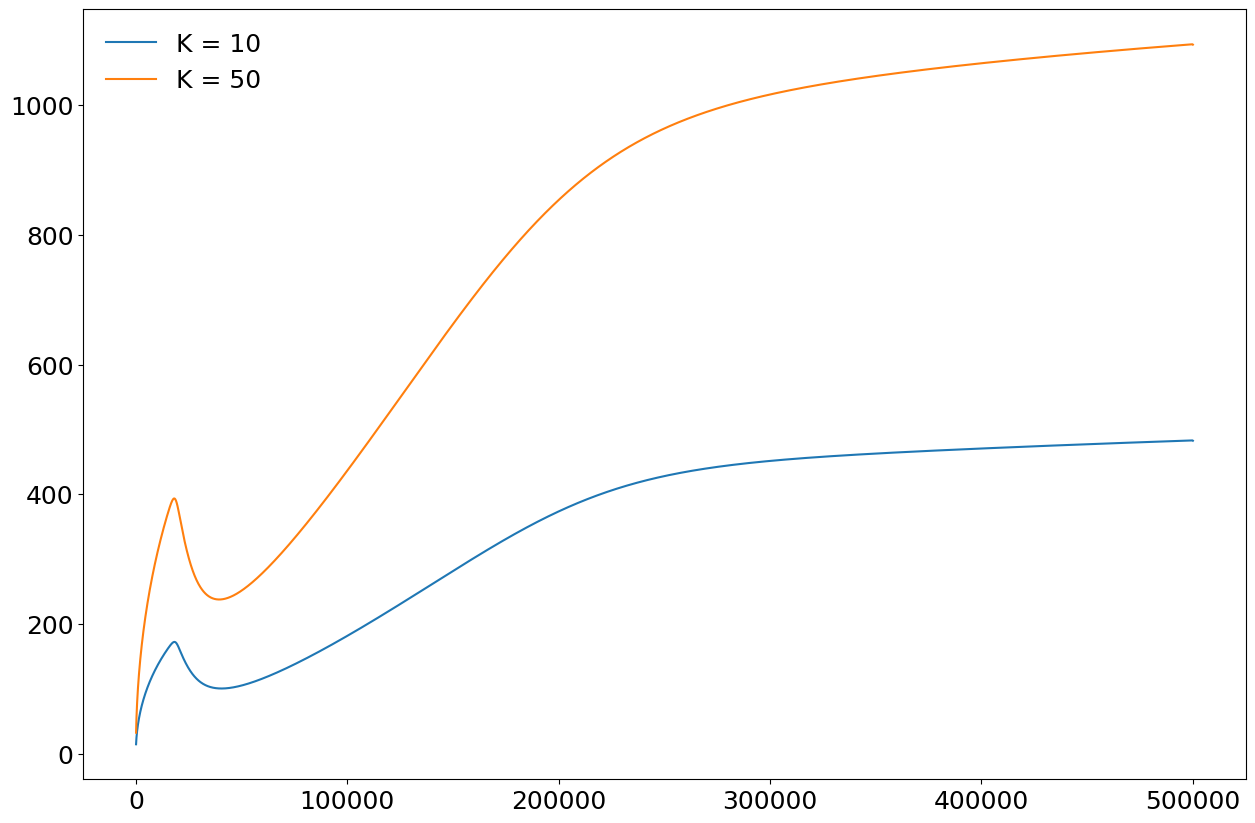

In [53]:
wrf          = wind_reduction_factor(Rs, Vs, 10, C, fcr) # azimuthal wind
Vs_try       = Vs / wrf
d0           = delta0(Rs, Vs_try, 10, fcr)
plt.plot(rs, d0[0, :], label='K = 10')

wrf          = wind_reduction_factor(Rs, Vs, 50, C, fcr) # azimuthal wind
Vs_try       = Vs / wrf
d0           = delta0(Rs, Vs_try, 50, fcr)
plt.plot(rs, d0[0, :], label='K = 50')
plt.legend(frameon=False)

  0%|          | 0/33 [00:00<?, ?it/s]

(0.0, 2000.0)

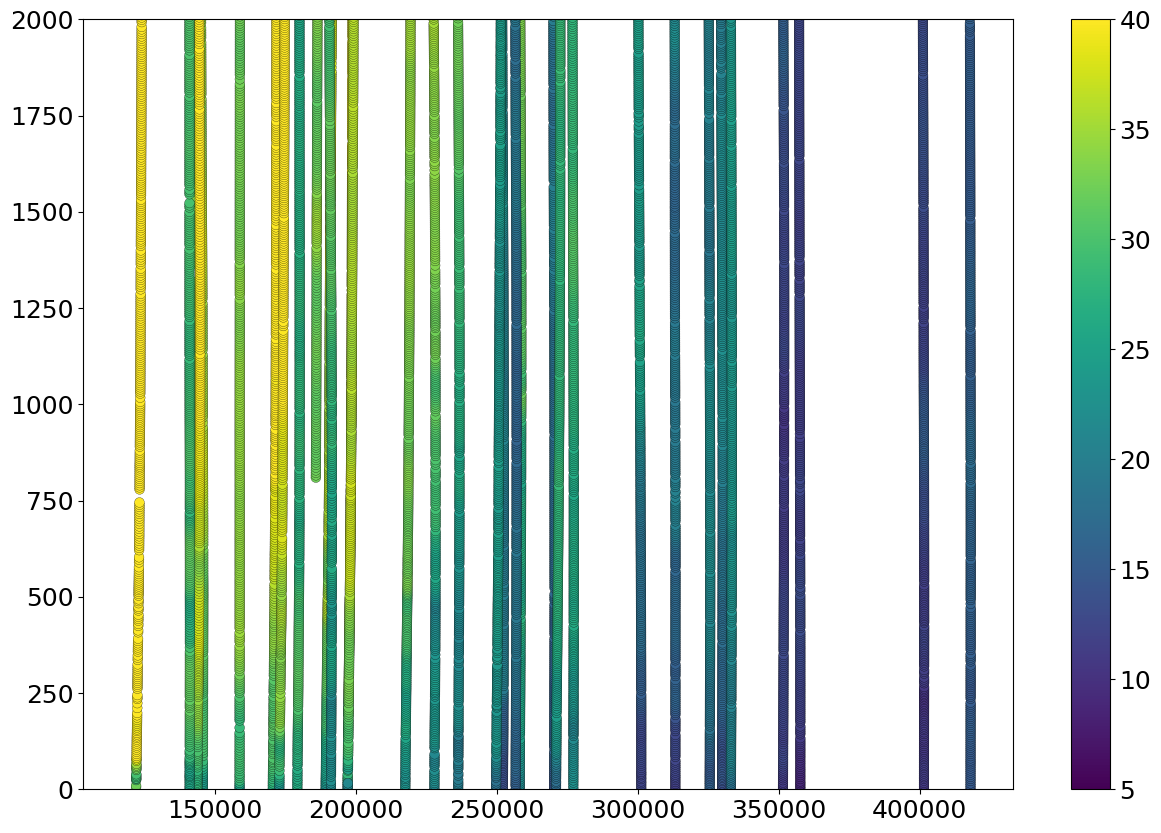

In [54]:
for file in tqdm(dps_all):
    dp        = xr.open_dataset(file)
    # Correct for storm movement and time difference
    dp        = get_new_aircraft_coords_based_on_storm_motion(dp, float(ds.storm_dir_ibt), float(ds.storm_speed_ibt), ds.time, float(ds.lon), float(ds.lat))
    # Add polar coordinates
    dp['rad_wind'] = dp.wspd * np.sin(np.deg2rad(dp.wdir + dp.th))
    dp['tan_wind'] = dp.wspd * np.cos(np.deg2rad(dp.wdir + dp.th))
    # Add total wind speed
    dp['hws'] = np.sqrt(dp.u_wind ** 2 + dp.v_wind ** 2)    
    sc = plt.scatter(dp.r, dp.gpsalt, c=dp.hws, vmin=5, vmax=40, cmap='viridis', edgecolor='black', linewidth=0.2, s=50)
plt.colorbar(sc)
plt.ylim(0, 2000)

In [55]:
# for file in tqdm(dps_all):
#     dp        = xr.open_dataset(file)
#     # Correct for storm movement and time difference
#     dp        = get_new_aircraft_coords_based_on_storm_motion(dp, float(ds.storm_dir_ibt), float(ds.storm_speed_ibt), ds.time, float(ds.lon), float(ds.lat))
#     # Add polar coordinates
#     dp['rad_wind'] = dp.wspd * np.sin(np.deg2rad(dp.wdir + dp.th))
#     dp['tan_wind'] = dp.wspd * np.cos(np.deg2rad(dp.wdir + dp.th))
#     # Add total wind speed
#     dp['hws'] = np.sqrt(dp.u_wind ** 2 + dp.v_wind ** 2)    
#     # sc = plt.scatter(dp.r, dp.gpsalt, c=dp.rad_wind, vmin=-15, vmax=5, cmap=plt.get_cmap('Blues_r', 10), edgecolor='black', linewidth=0.2, s=50)
#     plt.title('{:.1f}'.format(dp.r.mean() / 1000))
#     plt.scatter(dp.rad_wind, dp.alt)
#     plt.ylim(0, 2000)
#     plt.grid()
#     plt.show()
# plt.colorbar(sc)
# plt.ylim(0, 2000)

  0%|          | 0/33 [00:00<?, ?it/s]

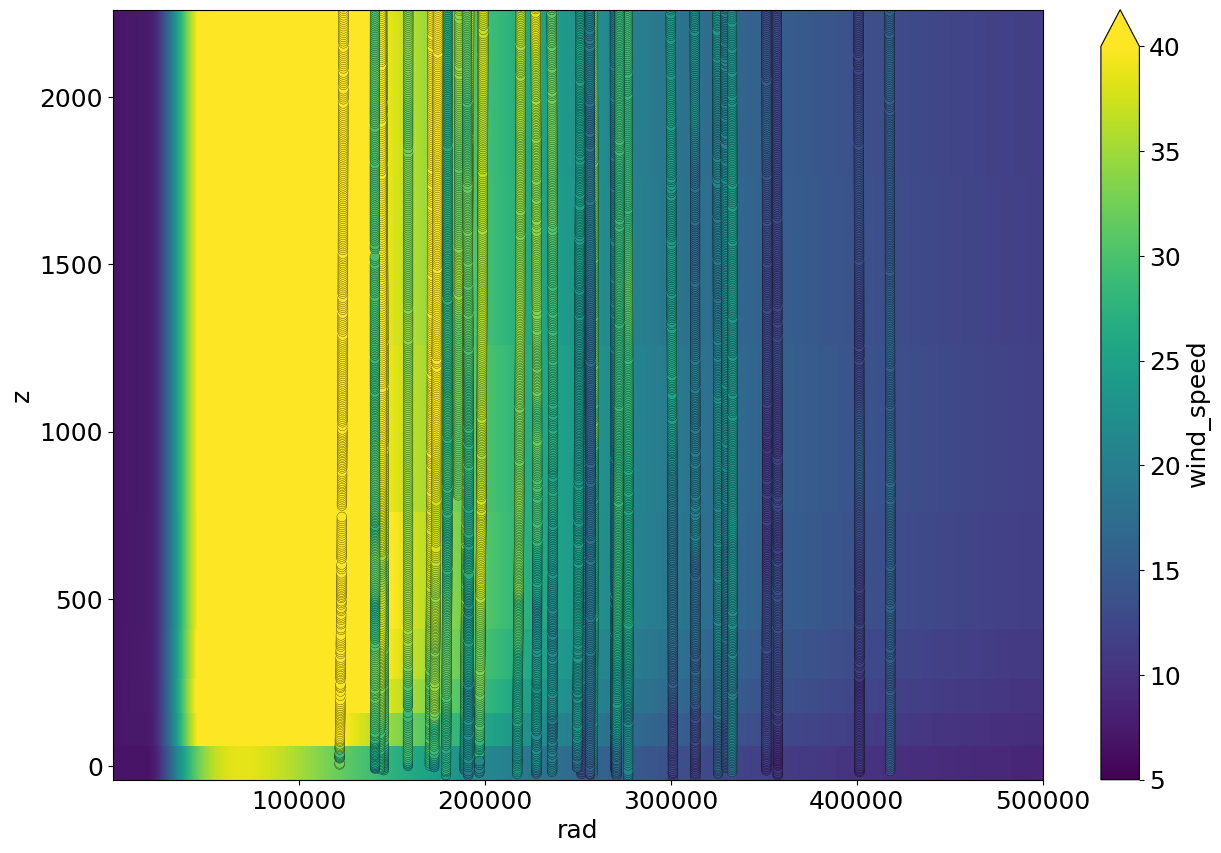

In [56]:
kep_pol2.mean(dim='theta').wind_speed.plot(vmin=5, vmax=40, cmap='viridis')
# dsp.wind_speed.transpose().plot(vmin=5, vmax=40, cmap='viridis')
for file in tqdm(dps_all):
    dp        = xr.open_dataset(file)
    dp        = get_new_aircraft_coords_based_on_storm_motion(dp, float(ds.storm_dir_ibt), float(ds.storm_speed_ibt), ds.time, float(ds.lon), float(ds.lat))
    dp['hws'] = np.sqrt(dp.u_wind ** 2 + dp.v_wind ** 2)
    plt.scatter(dp.r, dp.gpsalt, c=dp.hws, vmin=5, vmax=40, cmap='viridis', edgecolor='black', linewidth=0.2, s=50)

#### 3) Calibrate with total wind speed RMSE

In [57]:
dp_z_ref = np.linspace(0, 2000, 401)
DP_RADS  = []
DP_THS   = []
DP_HWS   = []

for file in tqdm(dps_all):
    try:
        dp        = xr.open_dataset(file)
        # Correct for storm movement and time difference
        dp        = get_new_aircraft_coords_based_on_storm_motion(dp, float(ds.storm_dir_ibt), float(ds.storm_speed_ibt), ds.time, float(ds.lon), float(ds.lat))
        # Add total wind speed
        dp['hws'] = np.sqrt(dp.u_wind ** 2 + dp.v_wind ** 2)
        # Interpolate on dp_z_ref
        ds_dp = xr.DataArray(data=np.array(dp.dropna(dim='time').hws), coords={'z': np.array(dp.dropna(dim='time').gpsalt)})
        ds_dp = ds_dp.where(~np.isnan(ds_dp.z)).dropna(dim='z') # Remove potential NaNs on coord z
        DP_HWS.append(np.array(ds_dp.interp(coords={'z': dp_z_ref})))
        # Add (r, th)-mean-coordinates
        DP_RADS.append(float(dp.r.mean()))
        DP_THS.append(float(dp.th.mean()))
    except ValueError:
        print('failed for file {}'.format(file))

# Concatenate in one big array
DP_OBS  = np.full((len(dp_z_ref), len(DP_THS), len(DP_RADS)), np.nan)
for idx in range(len(DP_RADS)):
    DP_OBS[:, idx, idx] = DP_HWS[idx]

  0%|          | 0/33 [00:00<?, ?it/s]

failed for file /home/arthur/data/tropical_cyclones/dropsondes/NOAA_field_experiment/samples/al122021/20210907N1_NETCDF/D20210907_181259_PQC.nc


In [58]:
# Compute RMSE
rmse(kep_pol1.interp(coords={'rad': DP_RADS, 'theta': DP_THS, 'z': dp_z_ref}).wind_speed, DP_OBS)

<xarray.DataArray 'wind_speed' ()> Size: 8B
array(6.65861257)

In [59]:
rmse(kep_pol2.interp(coords={'rad': DP_RADS, 'theta': DP_THS, 'z': dp_z_ref}).wind_speed, DP_OBS)

<xarray.DataArray 'wind_speed' ()> Size: 8B
array(5.12426544)

#### Compare inflow angle

In [60]:
### Compute the scatterometer inflow angle

# 07 September
# Metop-A vers 23:00: OK
# Metop-B vers minuit
# Metop-C vers 14:00: OK

# Open data
metopa = xr.open_dataset('/home/arthur/data/scatterometer/samples/ascat_20210907_225400_metopa_77247_eps_o_coa_3202_ovw.l2.nc')
metopa = metopa.isel(NUMCELLS=slice(0, 40), NUMROWS=slice(100, 250))

# metopa.wind_speed.plot(cmap=cwnd, norm=normalizer)

# Get center position from IBTrACS
ds_ibt                = xr.open_dataset('/home/arthur/data/tropical_cyclones/ibtracs/24032025/IBTrACS.ALL.v04r01.nc')[['usa_lon', 'usa_lat', 'usa_atcf_id']]
ds_ibt['usa_atcf_id'] = ds_ibt['usa_atcf_id'].astype(str, copy=False) 
dsi                   = ds_ibt.where(ds_ibt.usa_atcf_id == ds.id.item().upper(), drop=True).isel(storm=0)
dsi_interp            = dsi.assign_coords({'date_time': dsi['time']}).dropna(dim='date_time', subset=['usa_lat'])[['usa_lon', 'usa_lat']].drop_indexes('date_time').interp(date_time=metopa.time.mean())
lon_cen, lat_cen      = float(dsi_interp.usa_lon), float(dsi_interp.usa_lat)

from pyproj import CRS, Geod

lons        = np.array(metopa.lon)
lats        = np.array(metopa.lat)

lons_center = np.ones_like(lons) * lon_cen
lats_center = np.ones_like(lats) * lat_cen

geod_wgs84        = CRS("epsg:4326").get_geod()
forward_az, _, dr = geod_wgs84.inv(lons_center, lats_center, lons, lats)

def get_polar_theta(forward_az):
    '''INPUT: forward_az: 0° is North, 90° is East;
    OUTPUT: theta: 0° is East, 90° is North'''
    theta = (90 - forward_az) % 360 # 0° is North, 90° is East
    return theta

th = get_polar_theta(forward_az) # r is dr

metopa['radial_wind']     = metopa.wind_speed * np.sin(np.deg2rad(metopa.wind_dir + th))
metopa['tangential_wind'] = metopa.wind_speed * np.cos(np.deg2rad(metopa.wind_dir + th))

# Interpolate on reference grid
r_ref        = np.linspace(0, 500, int((500 // 1) + 1))
t_ref        = np.linspace(0, 360, 361)
r_grd, t_grd = np.meshgrid(r_ref, t_ref)
ws_pol       = griddata((dr.flatten() / 1000, th.flatten()), np.array(metopa.wind_speed).flatten(), (r_grd, t_grd), method='linear')
u_pol        = griddata((dr.flatten() / 1000, th.flatten()), np.array(metopa.radial_wind).flatten(), (r_grd, t_grd), method='linear')
v_pol        = griddata((dr.flatten() / 1000, th.flatten()), np.array(metopa.tangential_wind).flatten(), (r_grd, t_grd), method='linear')

# Create xr.Dataset
ds_pol = xr.Dataset(
    data_vars={
        'wind_speed':      (['theta', 'rad'], ws_pol),
        'radial_wind':     (['theta', 'rad'], u_pol),
        'tangential_wind': (['theta', 'rad'], v_pol),
        'lat_cen':         ([], lat_cen),
        'lon_cen':         ([], lon_cen),
    },
    coords={
        'theta': t_ref,
        'rad':   r_ref * 1000
    }
)

#################
### CARTESIAN ###
#################

def pol2cart(r, th):
    x = r * np.cos(th)
    y = r * np.sin(th)
    return x, y

ds_x, ds_y = pol2cart(dr, np.deg2rad(th))

### Interpolate on reference grid
# Create ref. grid, choose resolution
dim_ref      = np.linspace(-500, 500, int((500 // 1 * 2) + 1)) * 1000
x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)
# Interpolate on reference grid
ws_car       = griddata((ds_x.flatten(), ds_y.flatten()), np.array(metopa.wind_speed).flatten(), (x_ref, y_ref), method='linear')
u_car       = griddata((ds_x.flatten(), ds_y.flatten()), np.array(metopa.radial_wind).flatten(), (x_ref, y_ref), method='linear')
v_car       = griddata((ds_x.flatten(), ds_y.flatten()), np.array(metopa.tangential_wind).flatten(), (x_ref, y_ref), method='linear')

#  Create Dataset
ds_car = xr.Dataset(
    data_vars={
        'wind_speed':      (['x', 'y'], ws_car), 
        'radial_wind':     (['x', 'y'], u_car),
        'tangential_wind': (['x', 'y'], v_car),
        'lat_cen':         ([], lat_cen),
        'lon_cen':         ([], lon_cen),
    },
    coords={
        'x': dim_ref,
        'y': dim_ref
    }
)

# Filter the 0 m/s values
ds_pol['wind_speed'] = xr.where(ds_pol['wind_speed'] > 0, ds_pol['wind_speed'], np.nan)
ds_car['wind_speed'] = xr.where(ds_car['wind_speed'] > 0, ds_car['wind_speed'], np.nan)

# Inflow angle
# a_sct = np.rad2deg(np.arctan(abs(ds_pol.radial_wind.mean(dim='theta', skipna=True)) / abs(ds_pol.tangential_wind.mean(dim='theta', skipna=True))))
a_sct = np.rad2deg(np.arctan(abs(ds_pol.radial_wind) / abs(ds_pol.tangential_wind)))

In [61]:
a_kep = np.rad2deg(np.arctan(abs(kep_pol2.rad_wind) / abs(kep_pol2.tan_wind)))

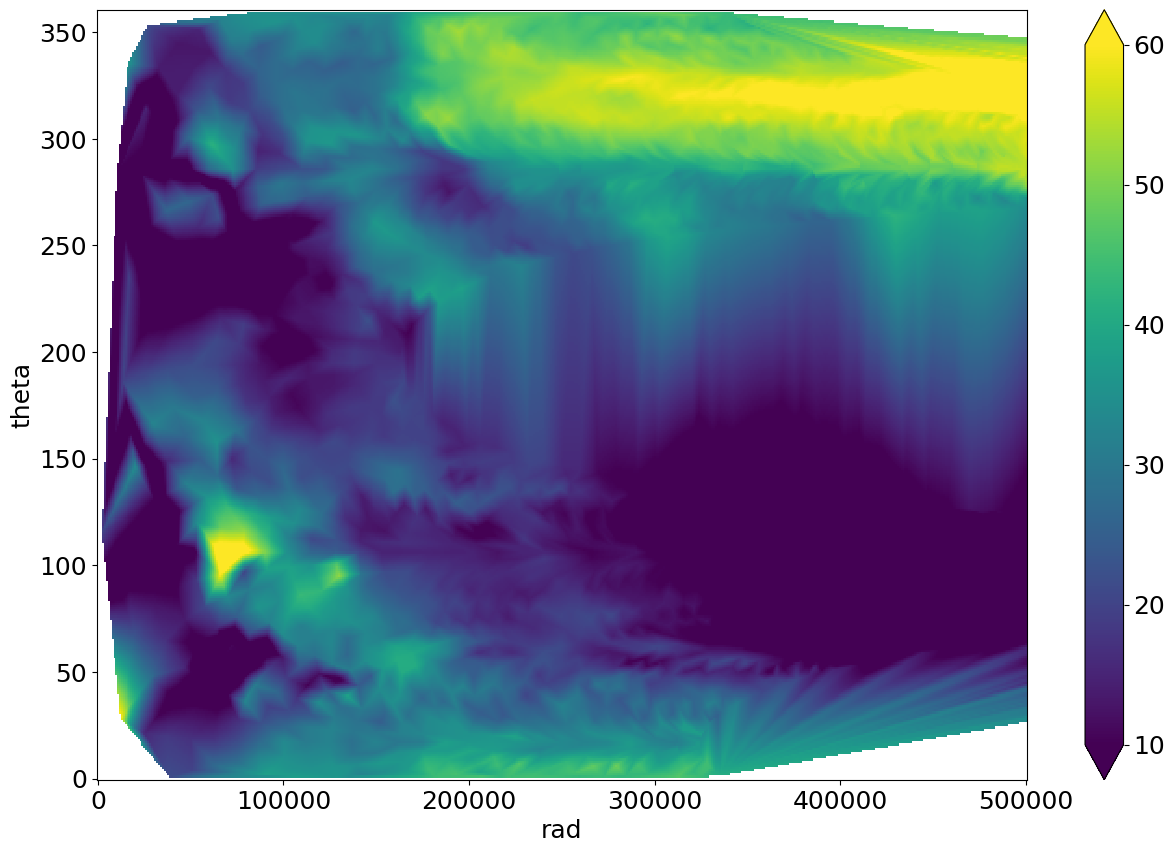

In [62]:
a_sct.plot(vmin=10, vmax=60)

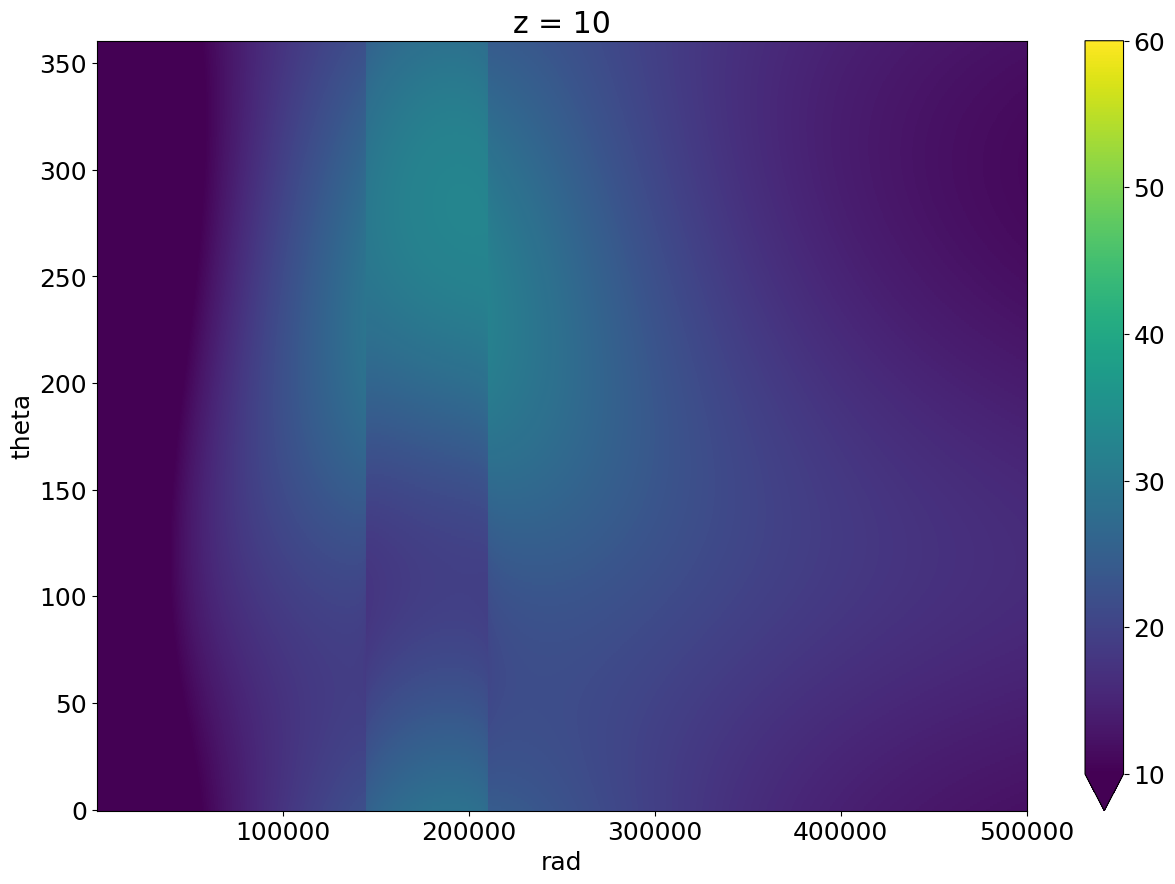

In [63]:
a_kep.sel(z=10).plot(vmin=10, vmax=60)

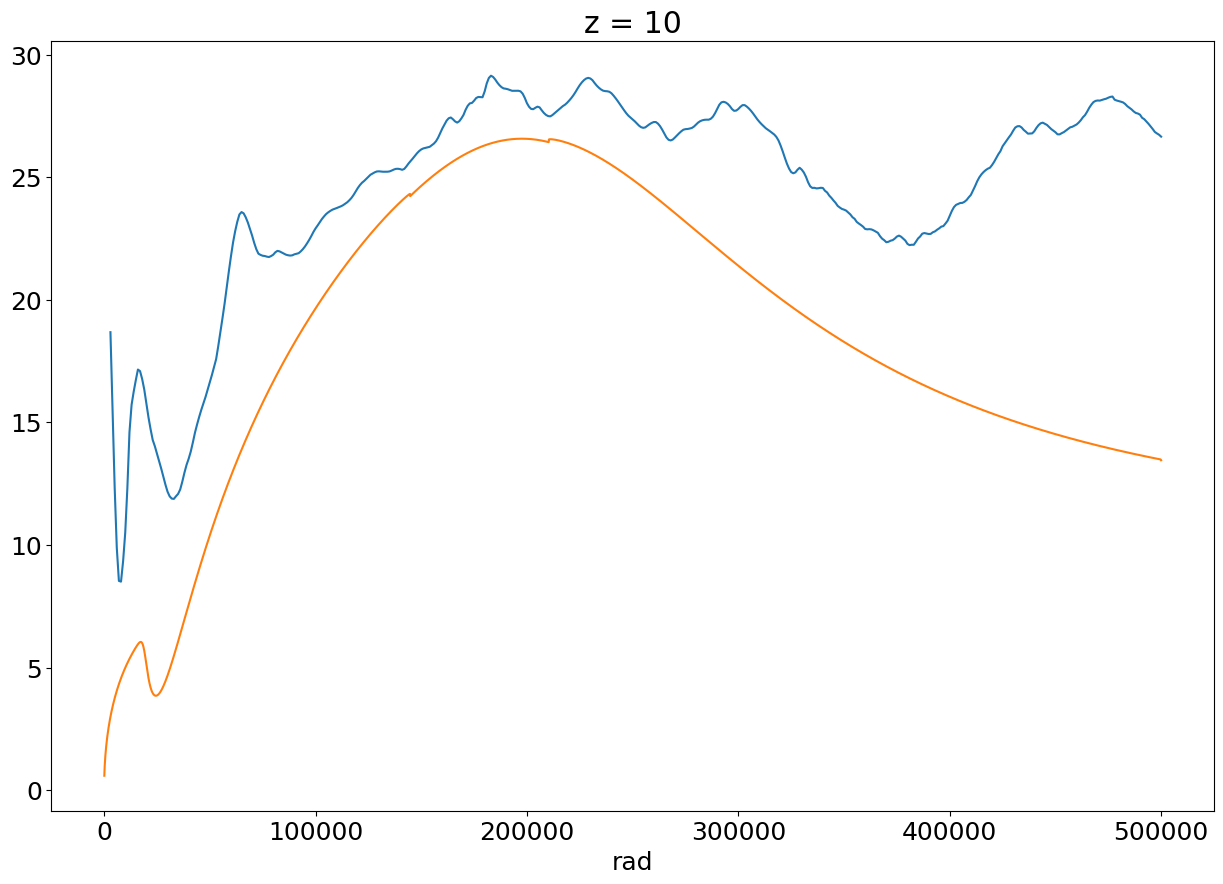

In [64]:
a_sct.mean(dim='theta').plot()
a_kep.sel(z=10).mean(dim='theta').plot()

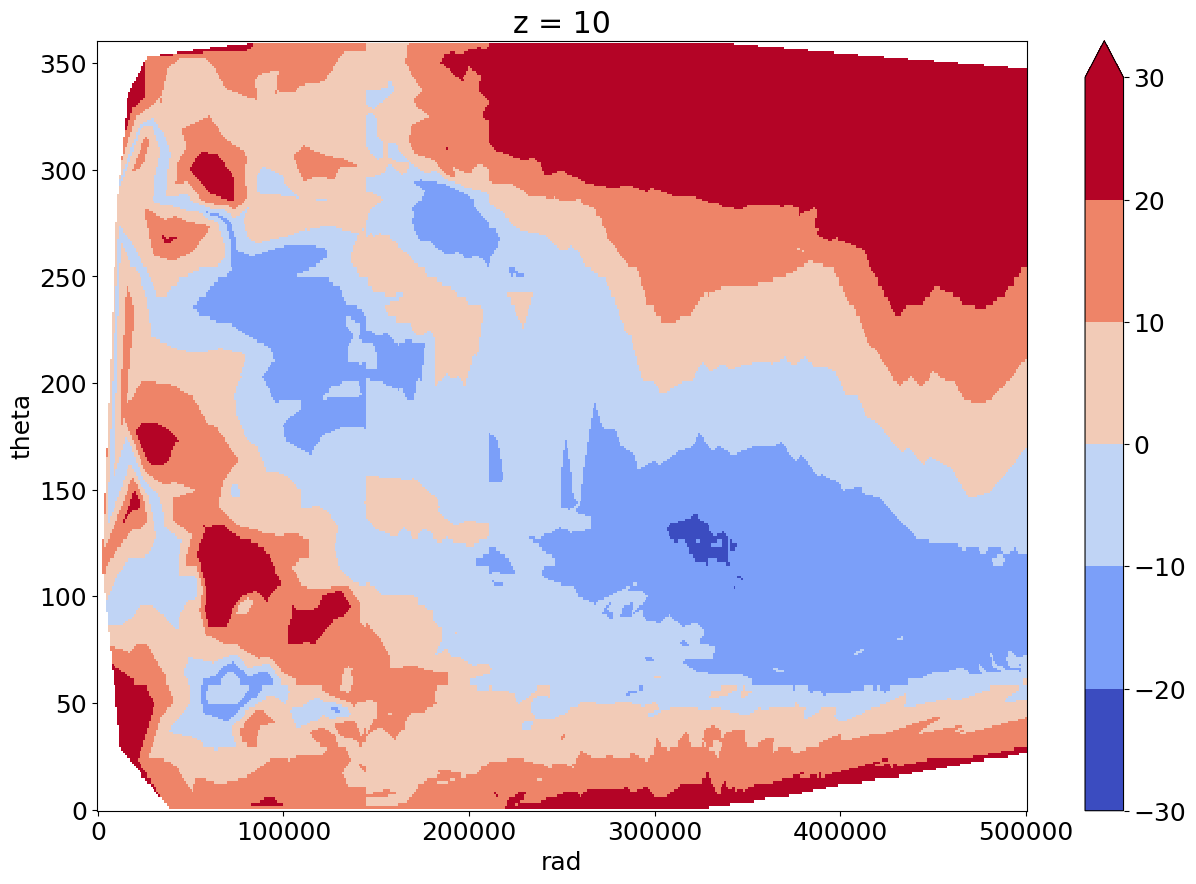

In [65]:
(a_sct - a_kep.sel(z=10).interp({'rad': np.array(a_sct.rad)})).plot(vmin=-30, vmax=30, cmap=plt.get_cmap('coolwarm', 6))

In [66]:
a_sct_car = np.rad2deg(np.arctan(abs(ds_car.radial_wind) / abs(ds_car.tangential_wind)))
a_kep_car = np.rad2deg(np.arctan(abs(kep_car2.rad_wind) / abs(kep_car2.tan_wind)))

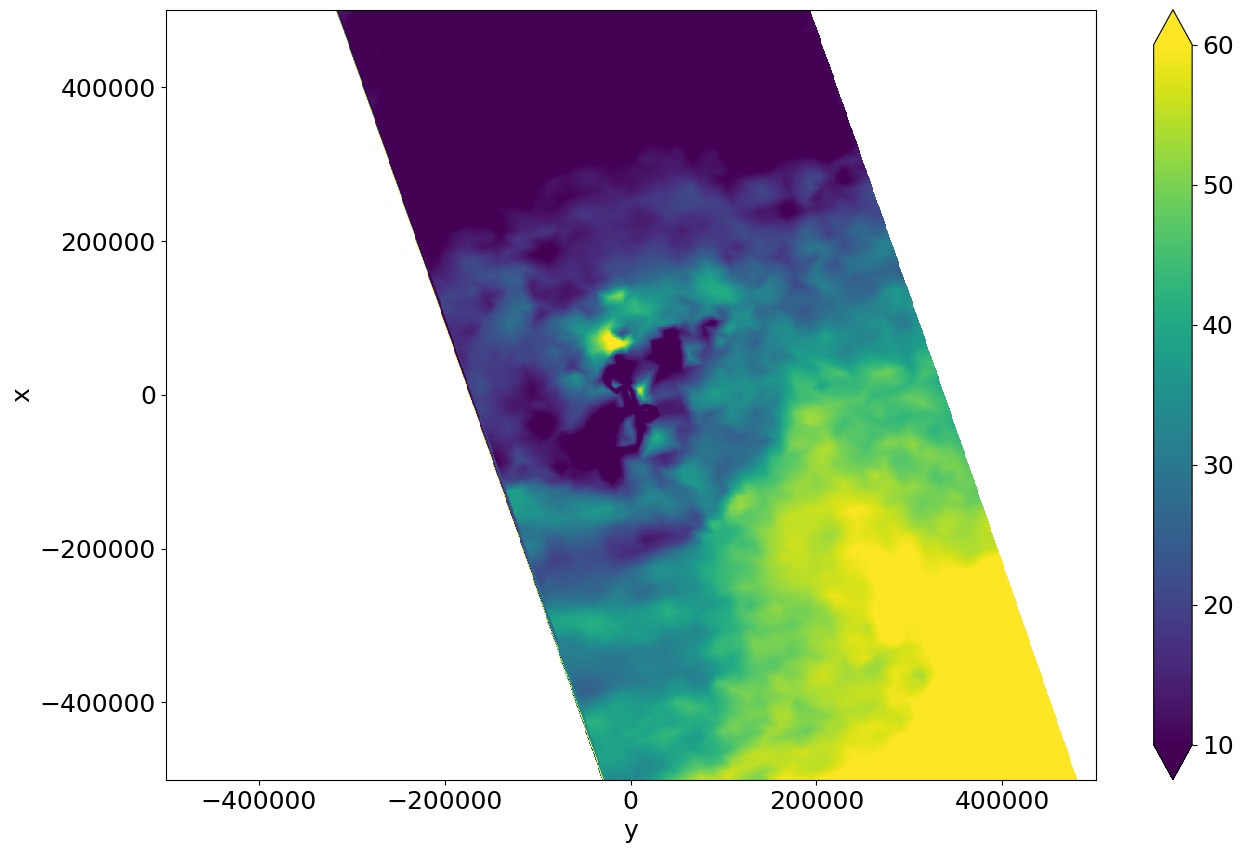

In [67]:
a_sct_car.plot(vmin=10, vmax=60)

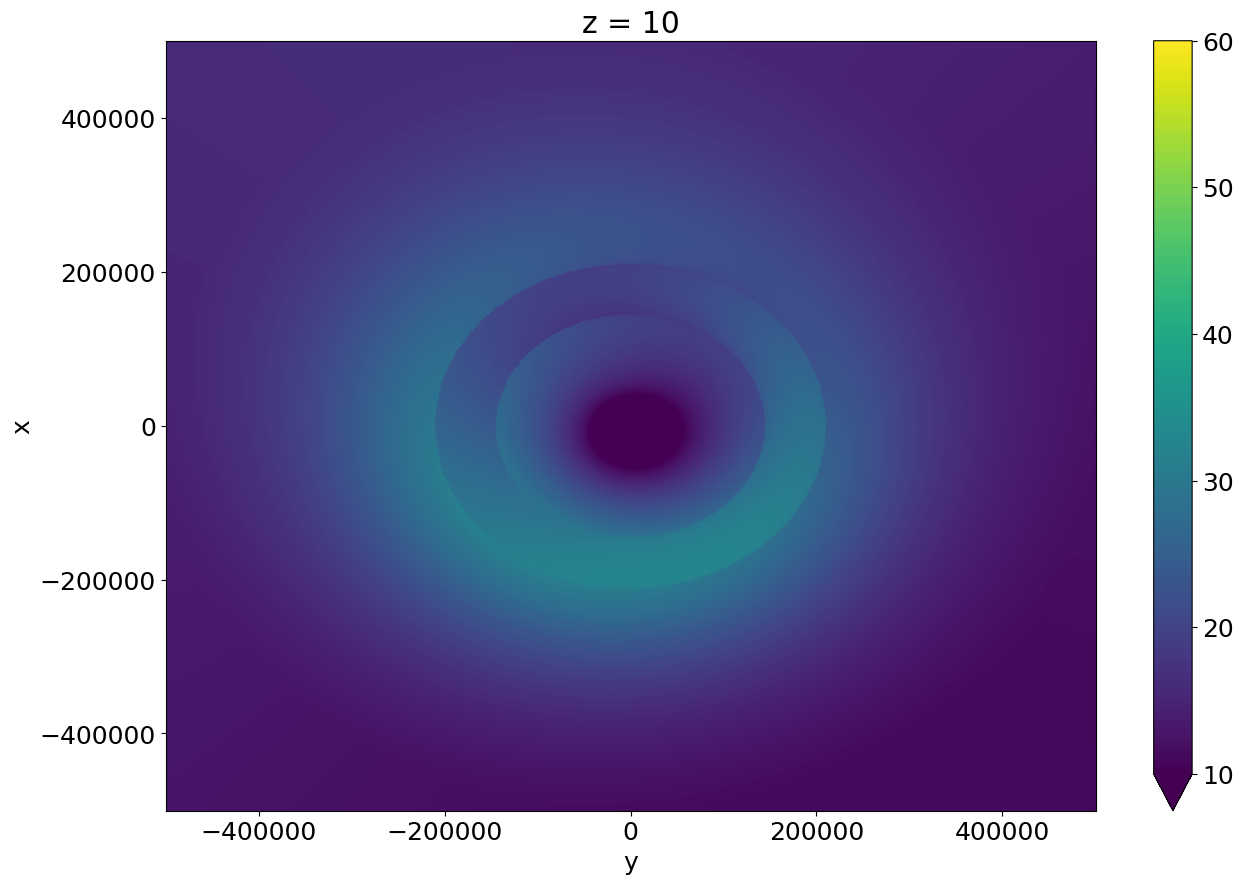

In [68]:
a_kep_car.sel(z=10).plot(vmin=10, vmax=60)

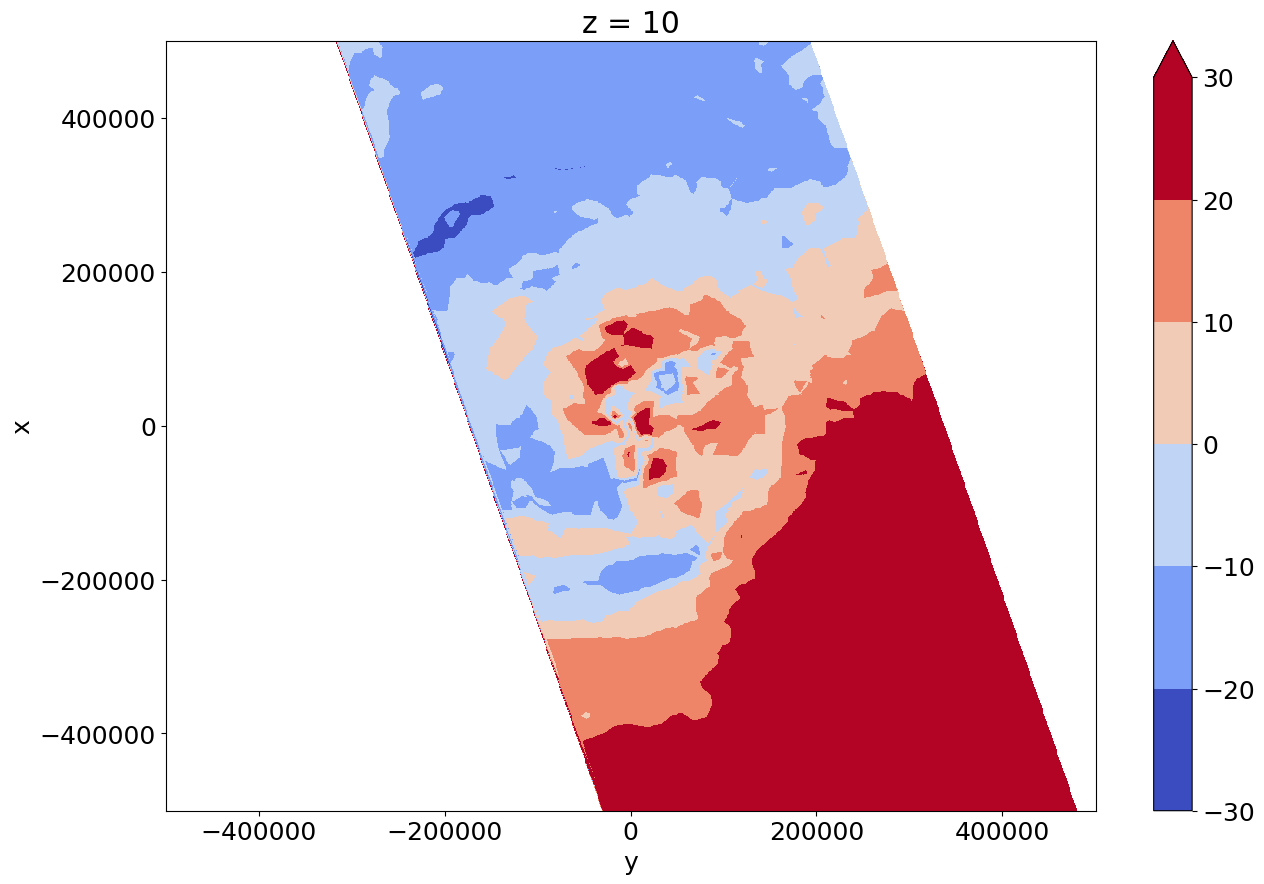

In [69]:
(a_sct_car - a_kep_car.sel(z=10)).plot(vmin=-30, vmax=30, cmap=plt.get_cmap('coolwarm', 6))

#### Other tests

In [ ]:
K     = 150
c2    = 0.9
kep_pol3, kep_car3 = get_z_kepert(THs, Rs, ths, rs, zs, Vs, K, C, c1, c2, fcr, z_ref, h)

  0%|          | 0/8 [00:00<?, ?it/s]

Polar dataset created.


  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
# Compute RMSE
rmse(kep_pol3.interp(coords={'rad': DP_RADS, 'theta': DP_THS, 'z': dp_z_ref}).wind_speed, DP_OBS)

In [ ]:
K     = 100
c2    = 0.8
kep_pol4, kep_car4 = get_z_kepert(THs, Rs, ths, rs, zs, Vs, K, C, c1, c2, fcr, z_ref, h)

In [ ]:
# Compute RMSE
rmse(kep_pol4.interp(coords={'rad': DP_RADS, 'theta': DP_THS, 'z': dp_z_ref}).wind_speed, DP_OBS)

In [ ]:
K     = 1
c2    = 0.5
kep_pol5, kep_car5 = get_z_kepert(THs, Rs, ths, rs, zs, Vs, K, C, c1, c2, fcr, z_ref, h)

In [ ]:
# Compute RMSE
rmse(kep_pol5.interp(coords={'rad': DP_RADS, 'theta': DP_THS, 'z': dp_z_ref}).wind_speed, DP_OBS)

In [ ]:
kep_pol5.sel(z=10).wind_speed.plot()